# 1. Importing the libraries and datasets

In [ ]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from scipy.spatial.distance import squareform
from matplotlib import cm
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

dataset1=pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/dataset1.csv') 
dataset2=pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/dataset2.csv') 
print(dataset1.shape)
print(dataset2.shape)

(2042, 1615)
(2042, 1615)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,1304,1305) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Clean from combinations that one molecules has all nan descriptors Nov 26
drop_id = np.concatenate([dataset1.id[dataset1.ABC=='n'].values,dataset2.id[dataset2.ABC=='n'].values])
len(drop_id)
dataset1 = dataset1[~dataset1.id.isin(drop_id)]
dataset2 = dataset2[~dataset2.id.isin(drop_id)]
print(dataset1.shape)
print(dataset2.shape)

(1861, 1615)
(1861, 1615)


In [ ]:
dataset1.head(5)

,id,smiles1,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,ADOSOE,CCC1=C(CC)C2=C(c3ccccc3)c4c(CC)c(CC)c5c6cccc(n...,81.49554264,57.05864535,0,0,135.945358,2.728066,5.315293,135.945358,1.332798,5.593096,8.390431,0.082259,4.449480,1978.454830,19.396616,9.912459,51.0,51.0,186.0,102.0,0.0,12.0,18.0,84.0,3.0,84.0,9.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,1392.000000,1566.000000,2754.000000,...,0.014924,0.009675,0.009366,0.007000,0.414349,18.0,13.0,0.384615,0.277778,1329.529335,7.870365,117.0,6.398595,7.349231,8.331586,9.313168,10.308186,11.300660,12.300578,13.297894,14.300028,311.899925,5.459586,0.0,6.874198,4.110874,8.507345,6.734592,10.246474,9.064274,12.047985,165.045327,1365.703304,7.342491,46827.0,237.0,600.0,777.0,32.604167,22.500000
1,ASOPUV,Cc1sc(C)c2SC3=C(Sc4c(C)sc(C)c4S3)Sc12,16.41793436,13.49800851,0,0,26.138494,2.540501,4.981792,26.138494,1.306925,3.980968,4.214951,0.210748,2.131785,107.969249,5.398462,5.374994,16.0,18.0,32.0,20.0,0.0,0.0,6.0,12.0,0.0,14.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,166.666667,160.000000,222.222222,...,0.024427,0.015853,0.000000,0.000000,0.517512,9.0,5.0,0.800000,0.444444,255.5462684,5.523562,23.0,4.779123,5.686975,6.621406,7.544861,8.478660,9.406811,10.340031,11.270128,12.203023,119.331019,3.850148,0.0,5.252273,3.044522,6.840547,5.533389,8.515392,7.694848,10.239495,70.970615,371.926326,11.622698,737.0,36.0,118.0,147.0,6.611111,4.111111
2,ASOQIK,COc1cc2SC3=C(Sc4cc(OC)c(OC)cc4S3)Sc2cc1OC,20.30389608,15.08127704,0,0,34.684121,2.504108,5.008215,34.684121,1.334005,4.205946,4.543092,0.174734,2.469119,202.604740,7.792490,6.266768,18.0,20.0,42.0,26.0,0.0,0.0,8.0,16.0,0.0,18.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,345.777778,317.333333,438.222222,...,0.013889,0.014155,0.010139,0.010611,0.470329,13.0,7.0,0.857143,0.461538,317.6001503,5.857981,29.0,4.962845,5.849325,6.755769,7.660585,8.571492,9.482122,10.395222,11.308591,12.223161,132.209112,4.077537,0.0,5.424950,0.000000,6.994850,0.000000,8.667508,0.000000,10.392037,61.556882,423.993143,10.095075,1653.0,48.0,142.0,173.0,8.111111,5.888889
3,ASOQOQ,Cc1sc(C)c2SC3=C(Sc4ccccc4S3)Sc12,15.57292821,12.07186337,0,0,25.544066,2.513330,4.968481,25.544066,1.344425,3.926927,4.030530,0.212133,2.035752,115.359218,6.071538,5.389905,17.0,19.0,29.0,19.0,0.0,0.0,5.0,10.0,0.0,14.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,168.222222,165.666667,224.222222,...,0.019245,0.008063,0.015625,0.000000,0.450800,9.0,5.0,0.800000,0.444444,234.400785,5.459432,22.0,4.709530,5.602119,6.517671,7.427144,8.345455,9.260748,10.180172,11.098061,12.018133,116.159035,3.806662,0.0,5.176150,2.397895,6.751101,4.844187,8.420021,7.002156,10.138362,67.536535,337.938605,11.653055,649.0,33.0,110.0,135.0,5.138889,3.972222
4,BODCEE,Cn1c2cccc(n2)n(Cc3ccc4ccc5cccc6ccc3c4c56)c7cc(...,79.72513902,42.60016799,0,0,133.964519,2.559373,5.118746,133.964519,1.395464,5.544732,8.048479,0.083838,4.347246,2193.605731,22.850060,9.955065,90.0,105.0,153.0,96.0,0.0,12.0,15.0,57.0,0.0,81.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.000000,1548.000000,2328.000000,...,0.010219,0.008083,0.006011,0.005157,0.329211,24.0,16.0,0.500000,0.333333,1021.878675,7.832890,114.0,6.347389,7.260523,8.185629,9.109746,10.038499,10.966075,11.896438,12.825716,13.757124,300.387139,5.433722,0.0,6.816736,0.000000,8.410721,0.000000,10.100739,0.000000,11.842941,138.604859,1239.492137,8.101256,49806.0,201.0,570.0,711.0,20.833333,20.083333


In [ ]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot
negatives1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/negatives/negative1.csv') 
negatives2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/negatives/negative2.csv') 
print(negatives1.shape)
print(negatives2.shape)

(11, 1615)
(11, 1615)


In [ ]:
# Set the columns of negative 1 and 2
numerical_cols = dataset1.columns[:]
negatives1.columns = numerical_cols
negatives2.columns = numerical_cols
negatives1.head(2)

,id,smiles1,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,c60:picene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.0,25.433737,0,0,93.161604,3.0,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.61895,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.05058,9,9,0.0,0.0,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.17694,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.0,12.0,8340,240,540,810,6.666667,10.0
1,c60:fluoroanthene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.0,25.433737,0,0,93.161604,3.0,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.61895,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.05058,9,9,0.0,0.0,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.17694,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.0,12.0,8340,240,540,810,6.666667,10.0


In [ ]:
# Unlabelled data

# Generate the unknown dataset (unlabelled), this might take some minutes

# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/Dataset/zinc15_dataset.csv')
val = unlabeled['Identifier'].values
length = len(val)

pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

pairs = pd.DataFrame(no_dups)
keys = unlabeled['Identifier'].values
values = unlabeled.iloc[:, 2:].values
d = {key:value for key, value in zip(keys, values)}
print(len(d['ZINC000000354958']))

1613


In [ ]:
mol1_data= list()
for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 2:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 2:].columns.values) 

# 2. EDA (Exploratory Data Analysis)

## 2.1 Set the label of postive and negative datasets
*We just explore thg binary dataset, so no normalization here*

### 2.1.1 Postive Dataset

In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['id'], dataset11, dataset22], axis=1), pd.concat([dataset1['id'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
#delete the row of 'id' and 'smiles' and Add suffix 1 and 2 for each Table
dataset1_w = dataset1.iloc[:,2:]
dataset1_w = dataset1_w.add_suffix('_1')
dataset2_w = dataset2.iloc[:,2:] 
dataset2_w = dataset2_w.add_suffix('_2')
print(dataset1_w.shape)
print(dataset2_w.shape)

(1861, 1613)
(1861, 1613)


In [ ]:
# Bidirectional concatenated postive dataset
positive_data = concat_bidirectional(dataset1_w,dataset2_w)

In [ ]:
# Assing the label = 1 for all the positive data
positive_data['label']=1
print(positive_data.shape)
positive_data.head(3)

(3722, 3228)


,id,ABC_1,ABCGG_1,nAcid_1,nBase_1,SpAbs_A_1,SpMax_A_1,SpDiam_A_1,SpAD_A_1,SpMAD_A_1,LogEE_A_1,VE1_A_1,VE2_A_1,VE3_A_1,VR1_A_1,VR2_A_1,VR3_A_1,nAromAtom_1,nAromBond_1,nAtom_1,nHeavyAtom_1,nSpiro_1,nBridgehead_1,nHetero_1,nH_1,nB_1,nC_1,nN_1,nO_1,nS_1,nP_1,nF_1,nCl_1,nBr_1,nI_1,nX_1,ATS0dv_1,ATS1dv_1,ATS2dv_1,ATS3dv_1,...,JGI8_2,JGI9_2,JGI10_2,JGT10_2,Diameter_2,Radius_2,TopoShapeIndex_2,PetitjeanIndex_2,Vabc_2,VAdjMat_2,MWC01_2,MWC02_2,MWC03_2,MWC04_2,MWC05_2,MWC06_2,MWC07_2,MWC08_2,MWC09_2,MWC10_2,TMWC10_2,SRW02_2,SRW03_2,SRW04_2,SRW05_2,SRW06_2,SRW07_2,SRW08_2,SRW09_2,SRW10_2,TSRW10_2,MW_2,AMW_2,WPath_2,WPol_2,Zagreb1_2,Zagreb2_2,mZagreb1_2,mZagreb2_2,label
0,ADOSOE,81.49554264,57.05864535,0,0,135.945358,2.728066,5.315293,135.945358,1.332798,5.593096,8.390431,0.082259,4.449480,1978.454830,19.396616,9.912459,51.0,51.0,186.0,102.0,0.0,12.0,18.0,84.0,3.0,84.0,9.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,1392.000000,1566.000000,2754.000000,3327.000000,...,2.700000e-18,0.0,0.0,0.05058,9.0,9.0,0.0,0.0,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.17694,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.0,12.0,8340.0,240.0,540.0,810.0,6.666667,10.0,1
1,ASOPUV,16.41793436,13.49800851,0,0,26.138494,2.540501,4.981792,26.138494,1.306925,3.980968,4.214951,0.210748,2.131785,107.969249,5.398462,5.374994,16.0,18.0,32.0,20.0,0.0,0.0,6.0,12.0,0.0,14.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,166.666667,160.000000,222.222222,187.555556,...,2.240000e-18,0.0,0.0,0.05058,9.0,9.0,0.0,0.0,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.17694,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.0,12.0,8340.0,240.0,540.0,810.0,6.666667,10.0,1
2,ASOQIK,20.30389608,15.08127704,0,0,34.684121,2.504108,5.008215,34.684121,1.334005,4.205946,4.543092,0.174734,2.469119,202.604740,7.792490,6.266768,18.0,20.0,42.0,26.0,0.0,0.0,8.0,16.0,0.0,18.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,345.777778,317.333333,438.222222,493.111111,...,2.240000e-18,0.0,0.0,0.05058,9.0,9.0,0.0,0.0,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.17694,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.0,12.0,8340.0,240.0,540.0,810.0,6.666667,10.0,1


### 2.1.2 Negative Dataset

In [ ]:
def neg_concat_bidirectional(dataset11, dataset22):
  return pd.concat([pd.concat([negatives1['id'], dataset11, dataset22], axis=1), pd.concat([negatives1['id'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])

In [ ]:
#delete the row of 'id' and 'smiles'
negatives1_w = negatives1.iloc[:,2:]
negatives1_w = negatives1_w.add_suffix('_1')
negatives2_w = negatives2.iloc[:,2:] 
negatives2_w = negatives2_w.add_suffix('_2')
print(negatives1_w.shape)

print(negatives2_w.shape)

(11, 1613)
(11, 1613)


In [ ]:
# Bidirectional concatenated negative dataset
negatives_data = neg_concat_bidirectional(negatives1_w,negatives2_w)



In [ ]:
negatives_data['label'] = 0
print(negatives_data.shape)
negatives_data.head(3)

(22, 3228)


,id,ABC_1,ABCGG_1,nAcid_1,nBase_1,SpAbs_A_1,SpMax_A_1,SpDiam_A_1,SpAD_A_1,SpMAD_A_1,LogEE_A_1,VE1_A_1,VE2_A_1,VE3_A_1,VR1_A_1,VR2_A_1,VR3_A_1,nAromAtom_1,nAromBond_1,nAtom_1,nHeavyAtom_1,nSpiro_1,nBridgehead_1,nHetero_1,nH_1,nB_1,nC_1,nN_1,nO_1,nS_1,nP_1,nF_1,nCl_1,nBr_1,nI_1,nX_1,ATS0dv_1,ATS1dv_1,ATS2dv_1,ATS3dv_1,...,JGI8_2,JGI9_2,JGI10_2,JGT10_2,Diameter_2,Radius_2,TopoShapeIndex_2,PetitjeanIndex_2,Vabc_2,VAdjMat_2,MWC01_2,MWC02_2,MWC03_2,MWC04_2,MWC05_2,MWC06_2,MWC07_2,MWC08_2,MWC09_2,MWC10_2,TMWC10_2,SRW02_2,SRW03_2,SRW04_2,SRW05_2,SRW06_2,SRW07_2,SRW08_2,SRW09_2,SRW10_2,TSRW10_2,MW_2,AMW_2,WPath_2,WPol_2,Zagreb1_2,Zagreb2_2,mZagreb1_2,mZagreb2_2,label
0,c60:picene,60.0,25.433737,0,0,93.161604,3.0,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.61895,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,3840,...,0.00886,0.003906,0.004081,0.315692,11,6,0.833333,0.454545,243.784791,5.700440,26,4.859812,5.765191,6.680855,7.600402,8.523374,9.447860,10.374022,11.300907,12.228768,124.781192,3.970292,0,5.323010,0.000000,6.914731,0.00000,8.615590,0.000000,10.370455,57.194078,278.109550,7.725265,963,42,128,159,4.388889,4.694444,0
1,c60:fluoroanthene,60.0,25.433737,0,0,93.161604,3.0,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.61895,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,3840,...,0.00000,0.000000,0.000000,0.251811,6,4,0.500000,0.333333,171.174715,5.247928,19,4.553877,5.468060,6.398595,7.333676,8.274102,9.214631,10.157626,11.099756,12.043430,109.543753,3.663562,0,5.017280,2.397895,6.608001,4.94876,8.305731,7.260523,10.057453,64.259204,202.078250,7.772240,364,29,94,118,3.166667,3.416667,0
2,"c60:1,9dicyanoanthracene",60.0,25.433737,0,0,93.161604,3.0,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.61895,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,3840,...,0.00000,0.000000,0.000000,0.326494,7,5,0.400000,0.285714,208.515319,5.321928,20,4.574711,5.468060,6.378426,7.295056,8.215277,9.136586,10.058823,10.981234,11.903947,112.012121,3.713572,0,5.030438,0.000000,6.602588,0.00000,8.296297,0.000000,10.053673,51.696568,228.068748,8.771875,521,33,96,118,5.166667,4.166667,0


## 2.2 Merge the dataset

In [ ]:
# Merge the postive and negative
df_concat = pd.concat([positive_data, negatives_data])
df_concat

,id,ABC_1,ABCGG_1,nAcid_1,nBase_1,SpAbs_A_1,SpMax_A_1,SpDiam_A_1,SpAD_A_1,SpMAD_A_1,LogEE_A_1,VE1_A_1,VE2_A_1,VE3_A_1,VR1_A_1,VR2_A_1,VR3_A_1,nAromAtom_1,nAromBond_1,nAtom_1,nHeavyAtom_1,nSpiro_1,nBridgehead_1,nHetero_1,nH_1,nB_1,nC_1,nN_1,nO_1,nS_1,nP_1,nF_1,nCl_1,nBr_1,nI_1,nX_1,ATS0dv_1,ATS1dv_1,ATS2dv_1,ATS3dv_1,...,JGI8_2,JGI9_2,JGI10_2,JGT10_2,Diameter_2,Radius_2,TopoShapeIndex_2,PetitjeanIndex_2,Vabc_2,VAdjMat_2,MWC01_2,MWC02_2,MWC03_2,MWC04_2,MWC05_2,MWC06_2,MWC07_2,MWC08_2,MWC09_2,MWC10_2,TMWC10_2,SRW02_2,SRW03_2,SRW04_2,SRW05_2,SRW06_2,SRW07_2,SRW08_2,SRW09_2,SRW10_2,TSRW10_2,MW_2,AMW_2,WPath_2,WPol_2,Zagreb1_2,Zagreb2_2,mZagreb1_2,mZagreb2_2,label
0,ADOSOE,81.49554264,57.05864535,0,0,135.945358,2.728066,5.315293,135.945358,1.332798,5.593096,8.390431,0.082259,4.449480,1978.454830,19.396616,9.912459,51.0,51.0,186.0,102.0,0.0,12.0,18.0,84.0,3.0,84.0,9.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,1392.000000,1566.000000,2754.000000,3327.000000,...,2.700000e-18,0.0,0.0,0.050580,9.0,9.0,0.00,0.000000,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000,1
1,ASOPUV,16.41793436,13.49800851,0,0,26.138494,2.540501,4.981792,26.138494,1.306925,3.980968,4.214951,0.210748,2.131785,107.969249,5.398462,5.374994,16.0,18.0,32.0,20.0,0.0,0.0,6.0,12.0,0.0,14.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,166.666667,160.000000,222.222222,187.555556,...,2.240000e-18,0.0,0.0,0.050580,9.0,9.0,0.00,0.000000,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000,1
2,ASOQIK,20.30389608,15.08127704,0,0,34.684121,2.504108,5.008215,34.684121,1.334005,4.205946,4.543092,0.174734,2.469119,202.604740,7.792490,6.266768,18.0,20.0,42.0,26.0,0.0,0.0,8.0,16.0,0.0,18.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,345.777778,317.333333,438.222222,493.111111,...,2.240000e-18,0.0,0.0,0.050580,9.0,9.0,0.00,0.000000,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000,1
3,ASOQOQ,15.57292821,12.07186337,0,0,25.544066,2.513330,4.968481,25.544066,1.344425,3.926927,4.030530,0.212133,2.035752,115.359218,6.071538,5.389905,17.0,19.0,29.0,19.0,0.0,0.0,5.0,10.0,0.0,14.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,168.222222,165.666667,224.222222,197.000000,...,2.240000e-18,0.0,0.0,0.050580,9.0,9.0,0.00,0.000000,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000,1
4,BODCEE,79.72513902,42.60016799,0,0,133.964519,2.559373,5.118746,133.964519,1.395464,5.544732,8.048479,0.083838,4.347246,2193.605731,22.850060,9.955065,90.0,105.0,153.0,96.0,0.0,12.0,15.0,57.0,0.0,81.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.000000,1548.000000,2328.000000,2562.000000,...,2.700000e-18,0.0,0.0,0.050580,9.0,9.0,0.00,0.000000,231.5715766,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## 2.3 Calculate the Null Accuracy
Baseline accuracy that can be achieved by always predicting the most frequent class (“B has the highest frequency, so lets guess B every time”).

In [ ]:
df_concat['label'].value_counts(normalize=True)

1    0.994124
0    0.005876
Name: label, dtype: float64

## 2.4 Draw histogram

In [ ]:
df_concat = df_concat.fillna(0)
df_concat = df_concat.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

In [ ]:
def check_missing_data(df):
    # check for any missing data in the df (display in descending order)
    return df.isnull().sum().sort_values(ascending=False)
check_missing_data(df_concat)

label         0
MAXssNH2_1    0
MAXaasN_1     0
MAXddsN_1     0
MAXsssN_1     0
             ..
MATS7p_2      0
MATS6p_2      0
MATS5p_2      0
MATS4p_2      0
id            0
Length: 3228, dtype: int64

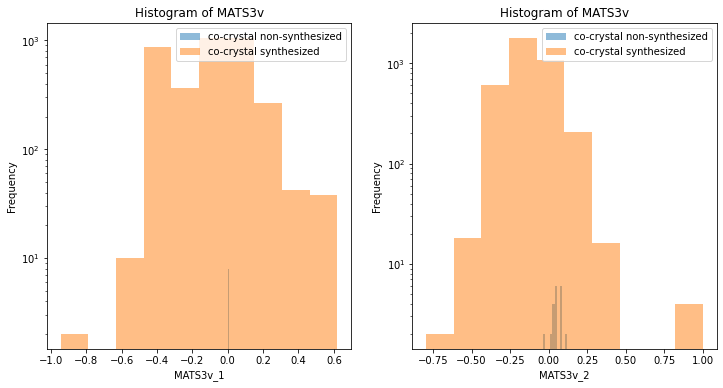

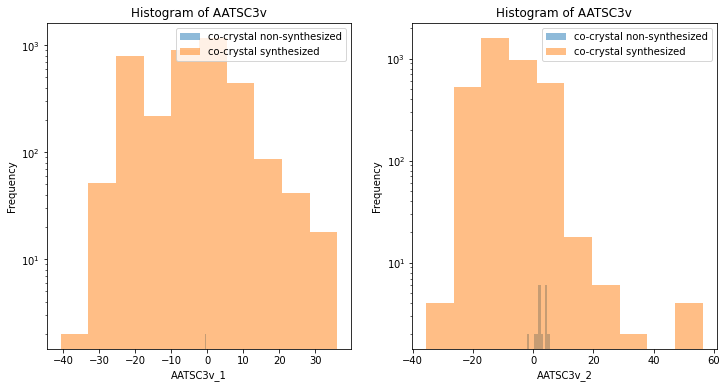

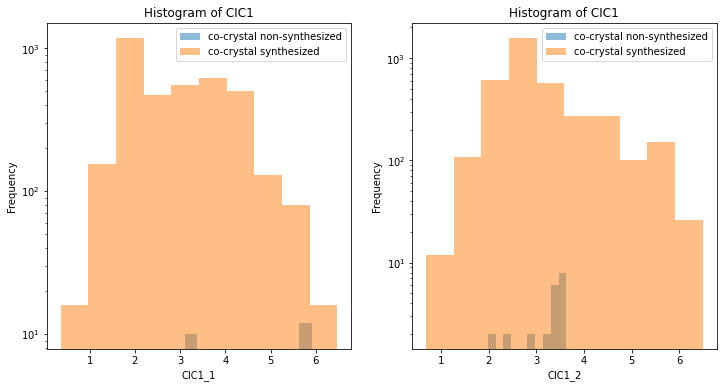

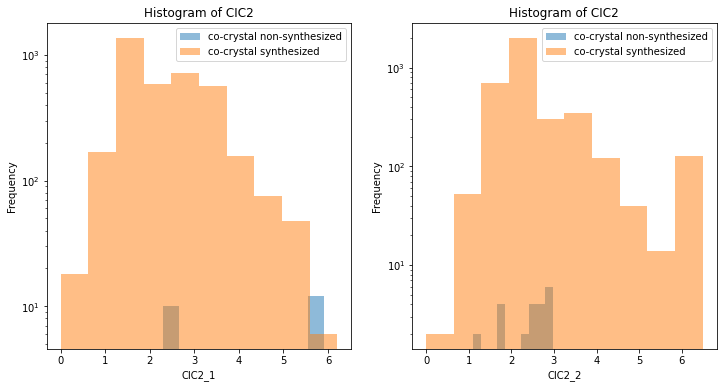

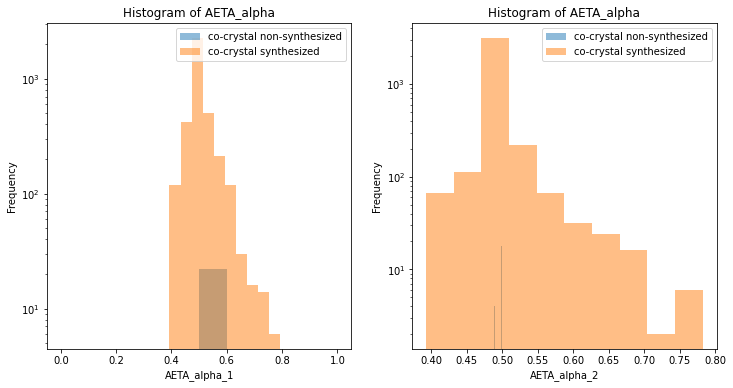

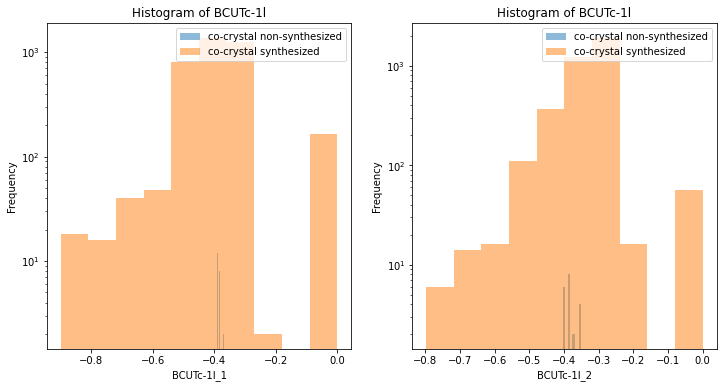

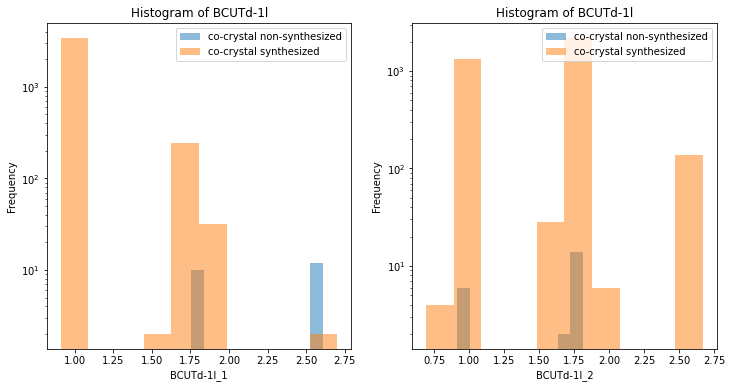

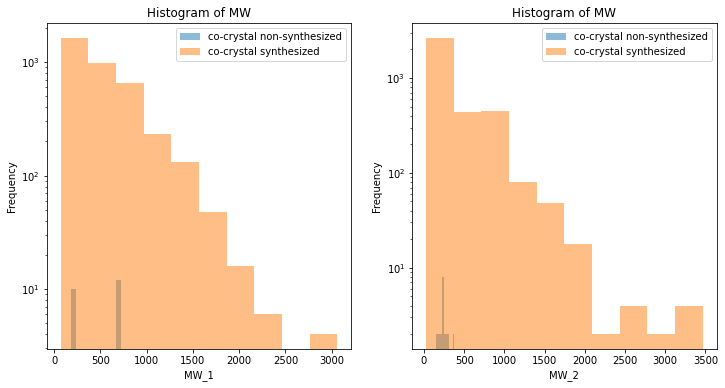

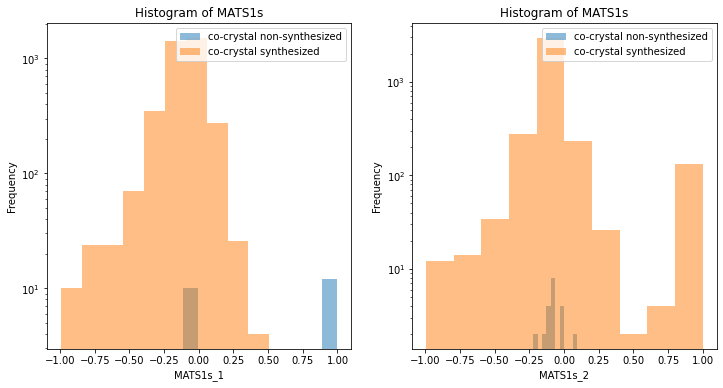

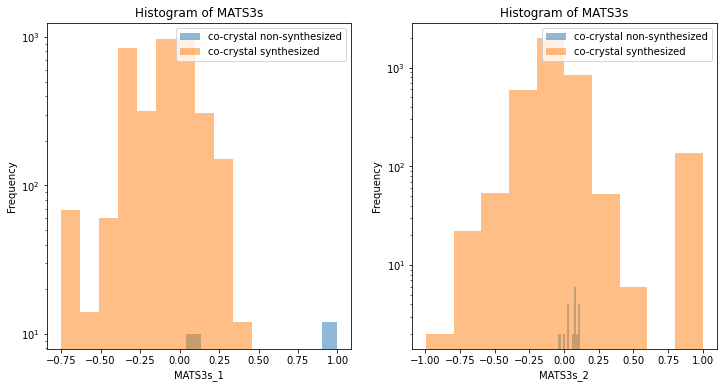

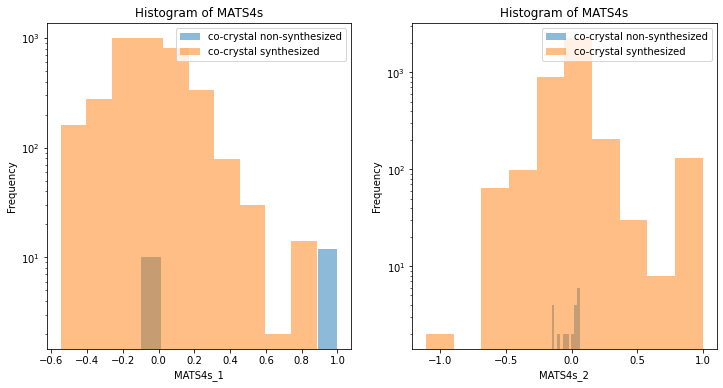

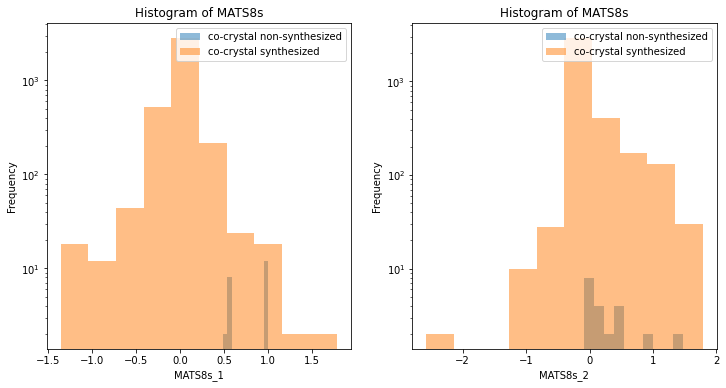

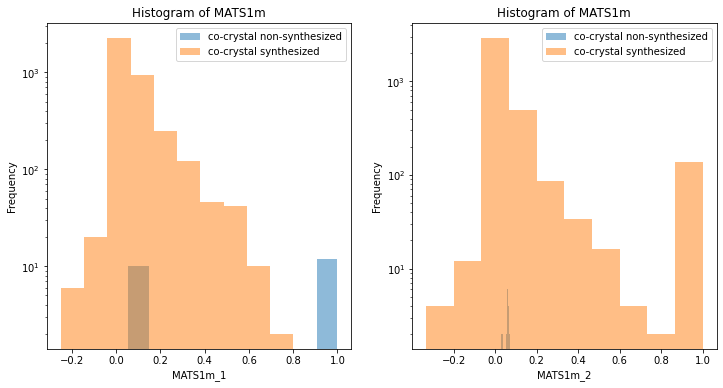

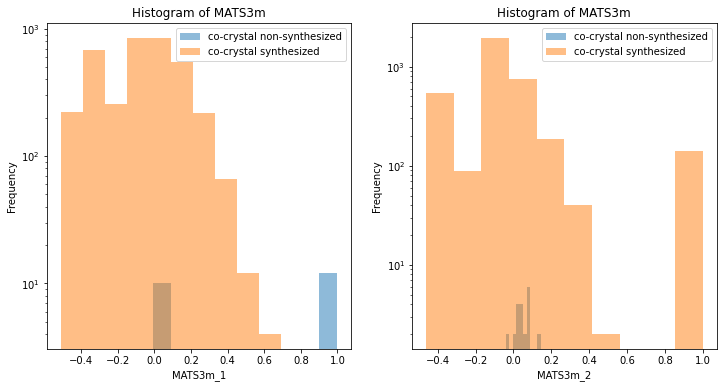

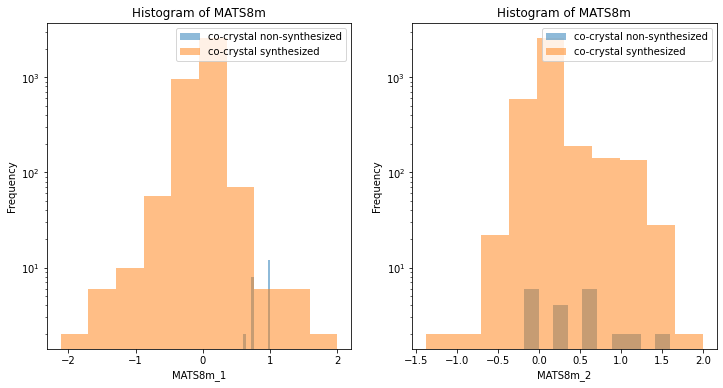

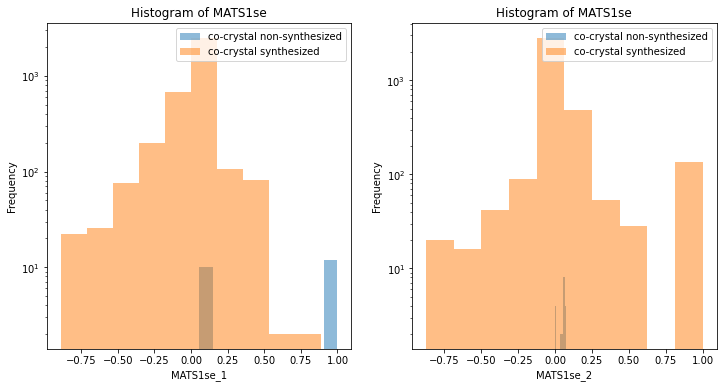

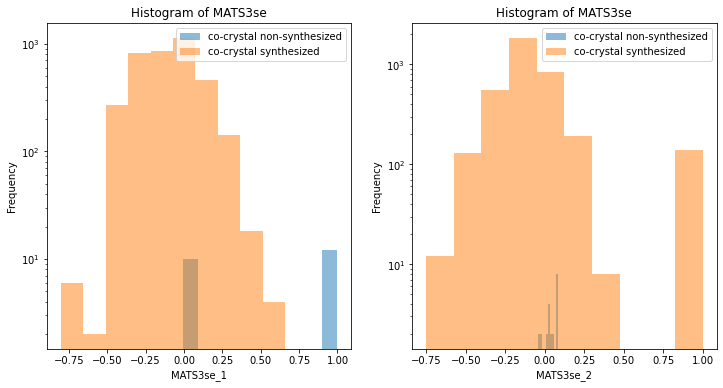

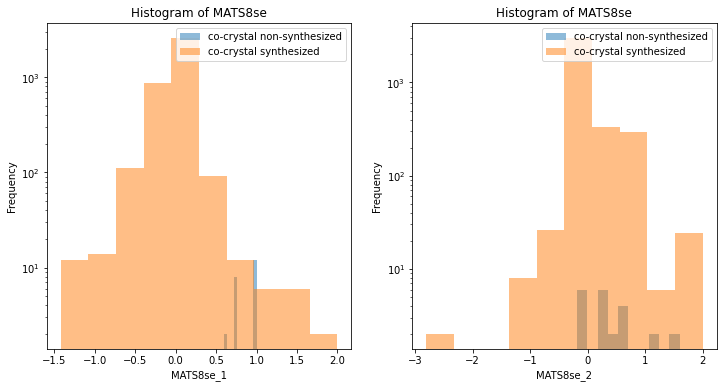

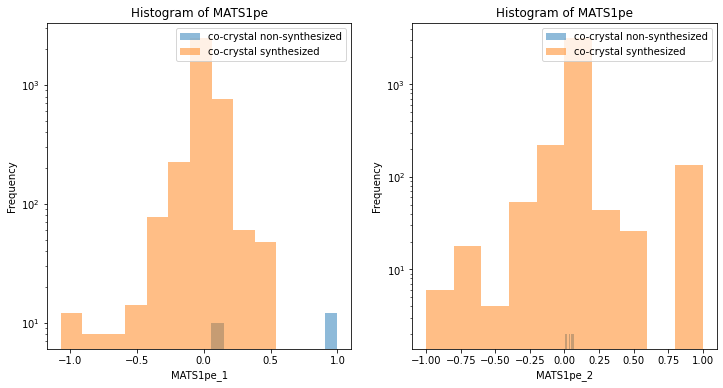

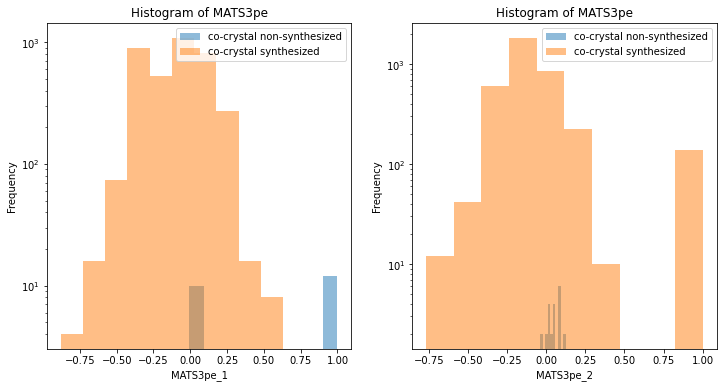

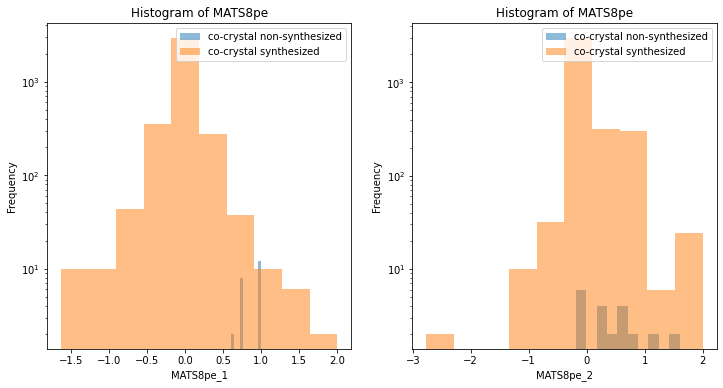

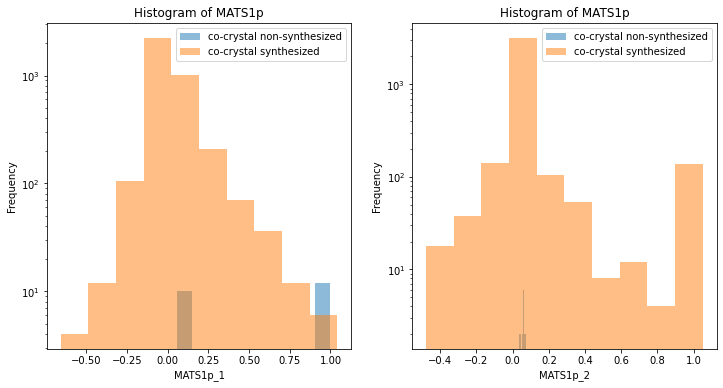

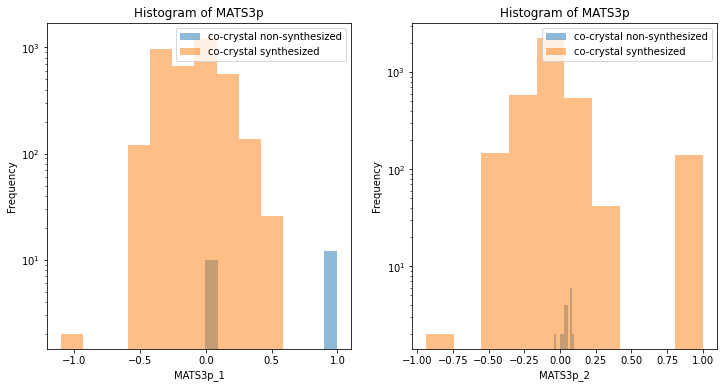

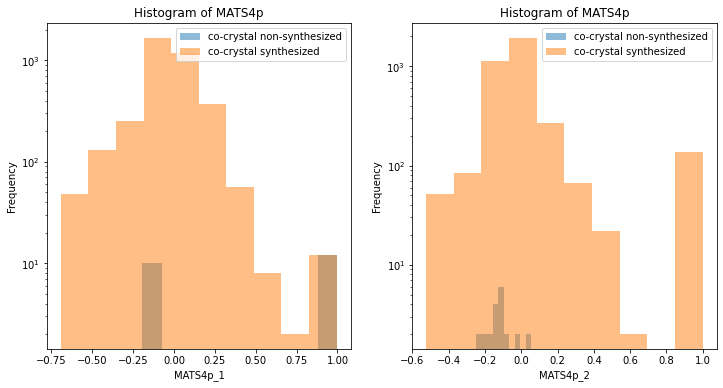

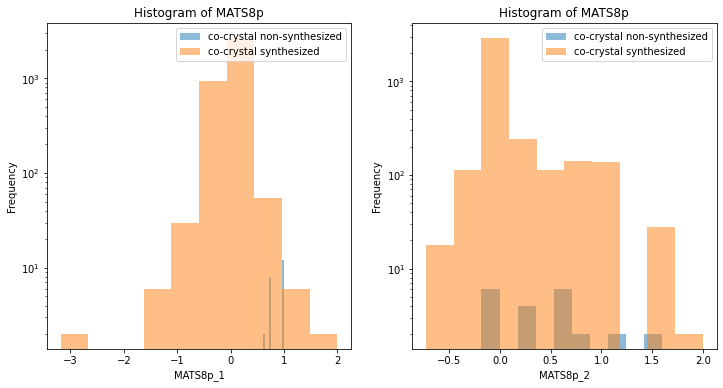

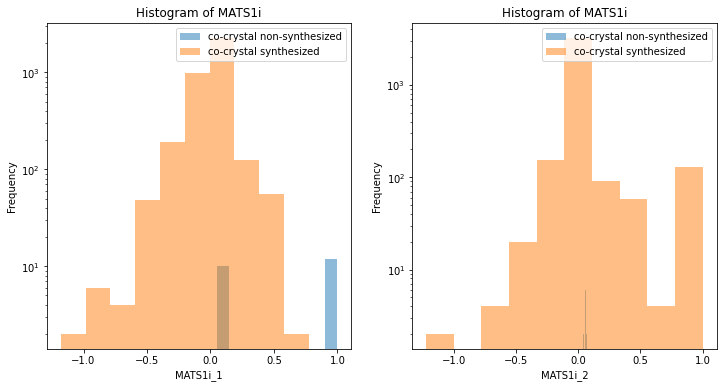

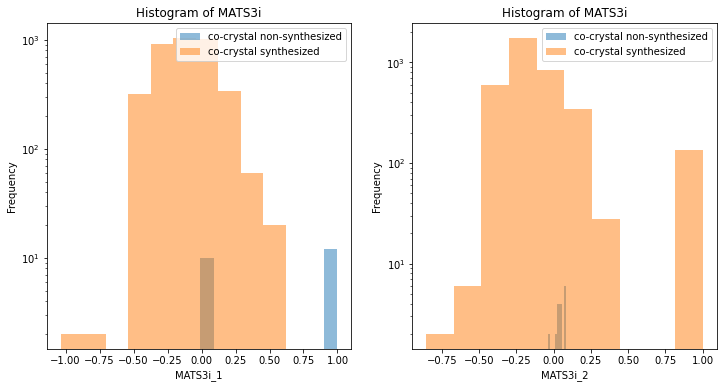

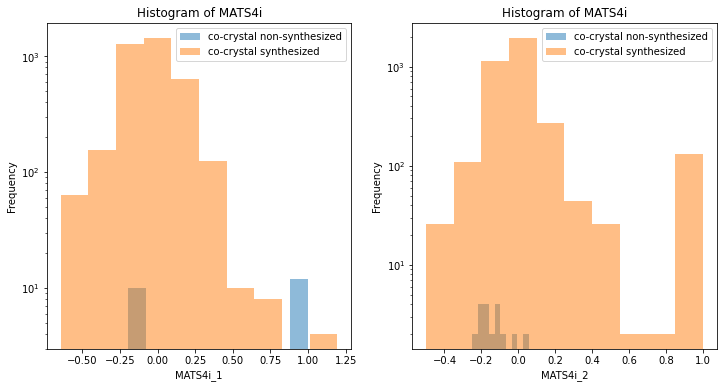

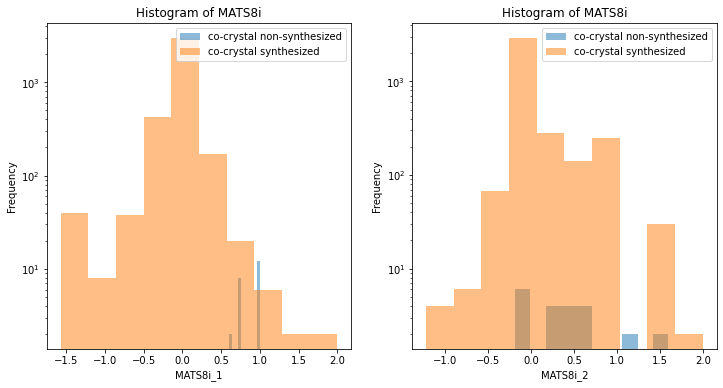

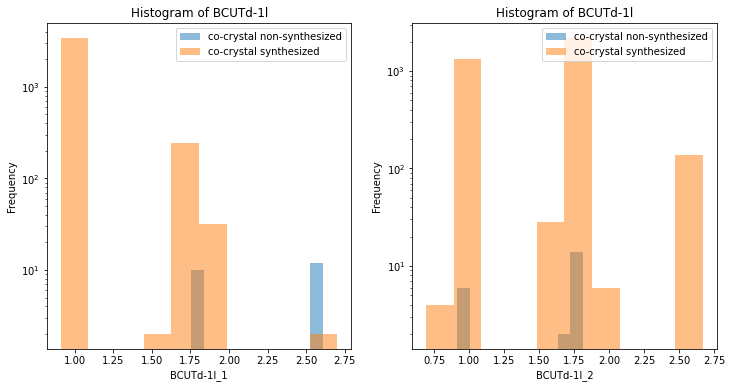

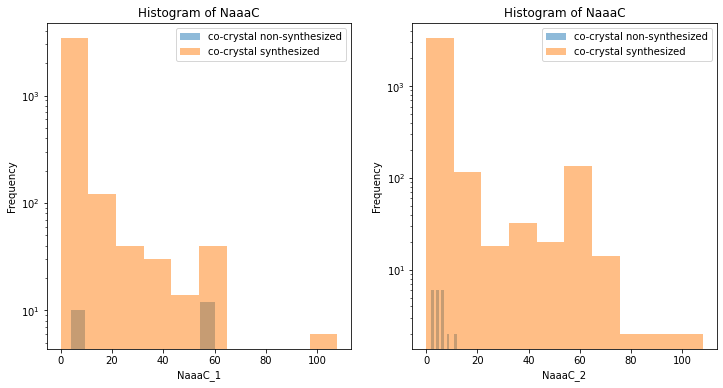

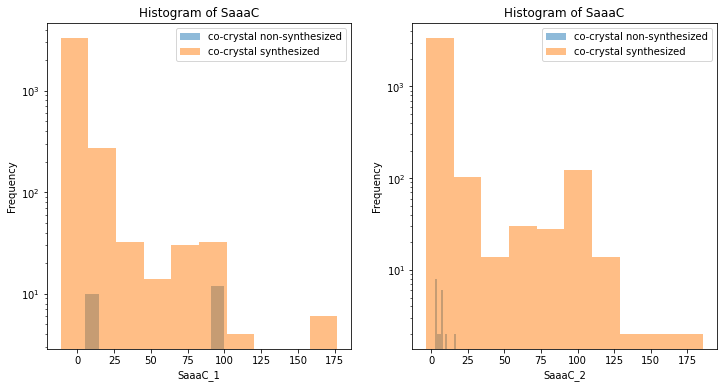

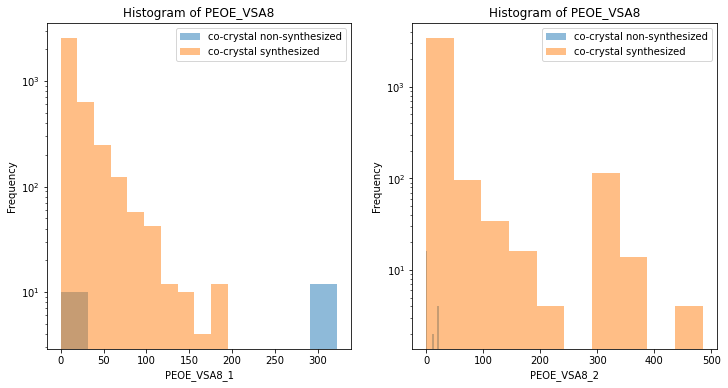

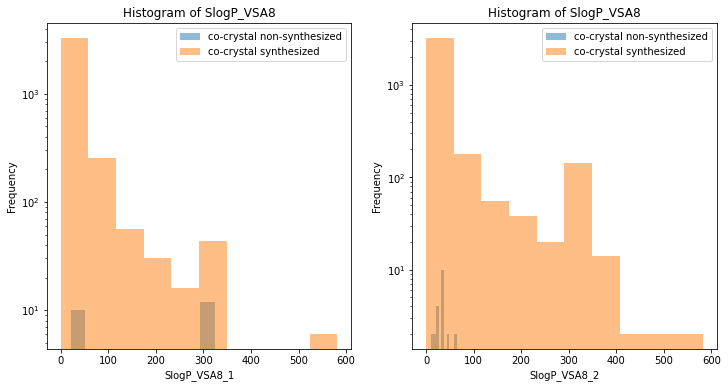

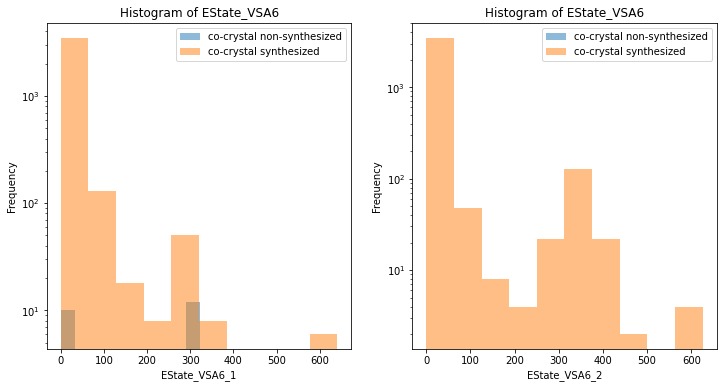

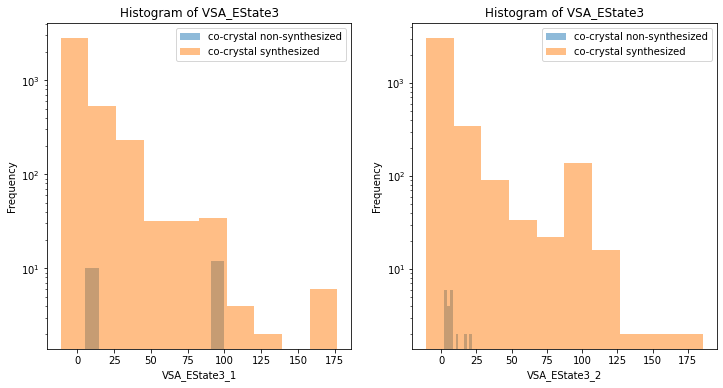

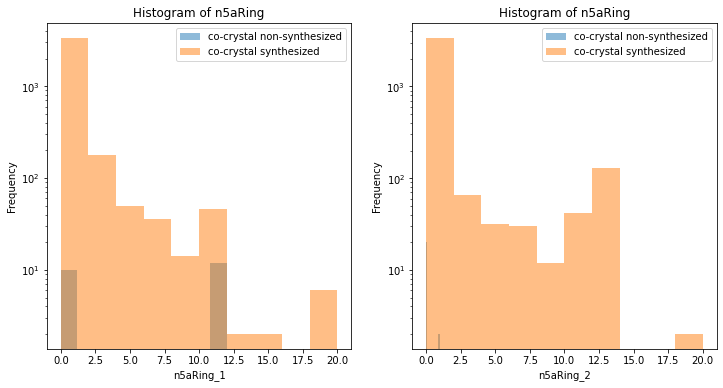

In [ ]:
for col in ['MATS3v','AATSC3v','CIC1','CIC2','AETA_alpha','BCUTc-1l','BCUTd-1l','MW','MATS1s', 'MATS3s', 'MATS4s', 'MATS8s', 'MATS1m', 'MATS3m',
       'MATS8m', 'MATS1se', 'MATS3se', 'MATS8se', 'MATS1pe',
       'MATS3pe', 'MATS8pe', 'MATS1p', 'MATS3p', 'MATS4p',
       'MATS8p', 'MATS1i', 'MATS3i', 'MATS4i', 'MATS8i',
       'BCUTd-1l', 'NaaaC', 'SaaaC', 'PEOE_VSA8', 'SlogP_VSA8',
       'EState_VSA6', 'VSA_EState3', 'n5aRing']:
  plt.figure(figsize=(12,6))
  for i in range(2):
   
    plt.subplot(1,2,i+1)
   
    plt.yscale('log')
    plt.hist(df_concat[df_concat['label']==0][col+'_'+ str(i+1)], 10, alpha=0.5,label='co-crystal non-synthesized')
    plt.hist(df_concat[df_concat['label']==1][col+'_'+ str(i+1)], 10, alpha=0.5,label='co-crystal synthesized')
    plt.legend(loc='upper right')
    plt.xlabel(col+'_'+ str(i+1))
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
  
  plt.show()  
  

# 3. Feature selection
I use both Postive and Negative for Fearture Selection

### 3.1.1 Feature selection based on the traditional binary classification (Will be test performances in the future)

In [ ]:
# Feature selection based on the traditional binary classification by Pearson correlation

# Characteristic matrix (#drop the column of 'id')
X = df_concat.drop('label', axis=1)
# Response variable
y = df_concat['label']
#create a mask of |Pearson Corr| >= 0.2
highly_correlated_features = df_concat.columns[df_concat.corr()['label'].abs() > .2]


In [ ]:
#delete the label
highly_correlated_features = highly_correlated_features.drop('label')
highly_correlated_features

Index(['SpMAD_A_1', 'AATS0d_1', 'AATS1d_1', 'AATS2d_1', 'AATS3d_1', 'AATS4d_1',
       'MATS1s_1', 'MATS3s_1', 'MATS4s_1', 'MATS8s_1', 'MATS1m_1', 'MATS3m_1',
       'MATS4m_1', 'MATS8m_1', 'MATS1se_1', 'MATS3se_1', 'MATS8se_1',
       'MATS1pe_1', 'MATS3pe_1', 'MATS8pe_1', 'MATS1p_1', 'MATS3p_1',
       'MATS4p_1', 'MATS8p_1', 'MATS1i_1', 'MATS3i_1', 'MATS4i_1', 'MATS8i_1',
       'GATS1d_1', 'GATS1v_1', 'GATS3v_1', 'GATS1i_1', 'GATS3i_1',
       'BCUTdv-1l_1', 'BCUTd-1l_1', 'AXp-0d_1', 'NaaaC_1', 'SaaaC_1', 'fMF_1',
       'IC0_1', 'IC1_1', 'SIC1_1', 'SIC2_1', 'BIC1_1', 'BIC2_1', 'PEOE_VSA8_1',
       'SlogP_VSA8_1', 'EState_VSA6_1', 'VSA_EState3_1', 'AMID_1',
       'n5aRing_1'],
      dtype='object')

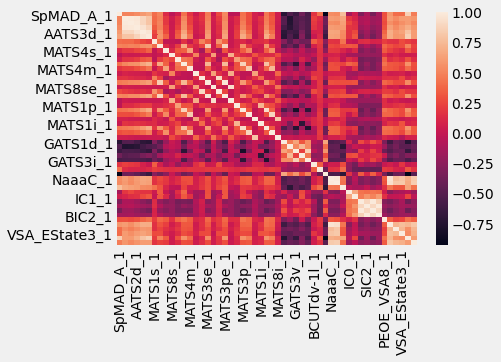

In [ ]:
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight') 
X_subsetted = X[highly_correlated_features]
sns.heatmap(X_subsetted.corr())


Test the algorithms performances

In [ ]:
# we just want to see the performances of the algorithms, so we do not need to split the dataset now
from sklearn.model_selection import GridSearchCV
def get_best_model_and_accuracy(model, params, X, y): 
  grid = GridSearchCV(model,params, error_score=0.) 
  grid.fit(X, y)   
  print("Best Accuracy: {}".format(grid.best_score_)) 
  print("Best Parameters: {}".format(grid.best_params_)) 
  print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))) 
  print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

In [ ]:
#Create benchmark machine learning pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier


# lr
lr_params = {'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']}
# KNN
knn_params = {'n_neighbors': [1, 3, 5, 7]}
# dtree
tree_params = {'max_depth':[None, 1, 3, 5, 7]}
 # rf
forest_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 1, 3, 5, 7]}

lr = LogisticRegression()
knn = KNeighborsClassifier() 
d_tree = DecisionTreeClassifier() 
forest = RandomForestClassifier()

get_best_model_and_accuracy(d_tree, tree_params, X, y)


Best Accuracy: 1.0
Best Parameters: {'max_depth': None}
Average Time to Fit (s): 1.55
Average Time to Score (s): 0.157


In [ ]:
# fit a decision tree on an imbalanced classification dataset
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# define model
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1) # summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

## It is not a good model, and ROC seems like out of working

Mean ROC AUC: 0.972


### 3.1.2 Feature selection based on pairwise correlations like in the paper and the github code (for Friday 20th)


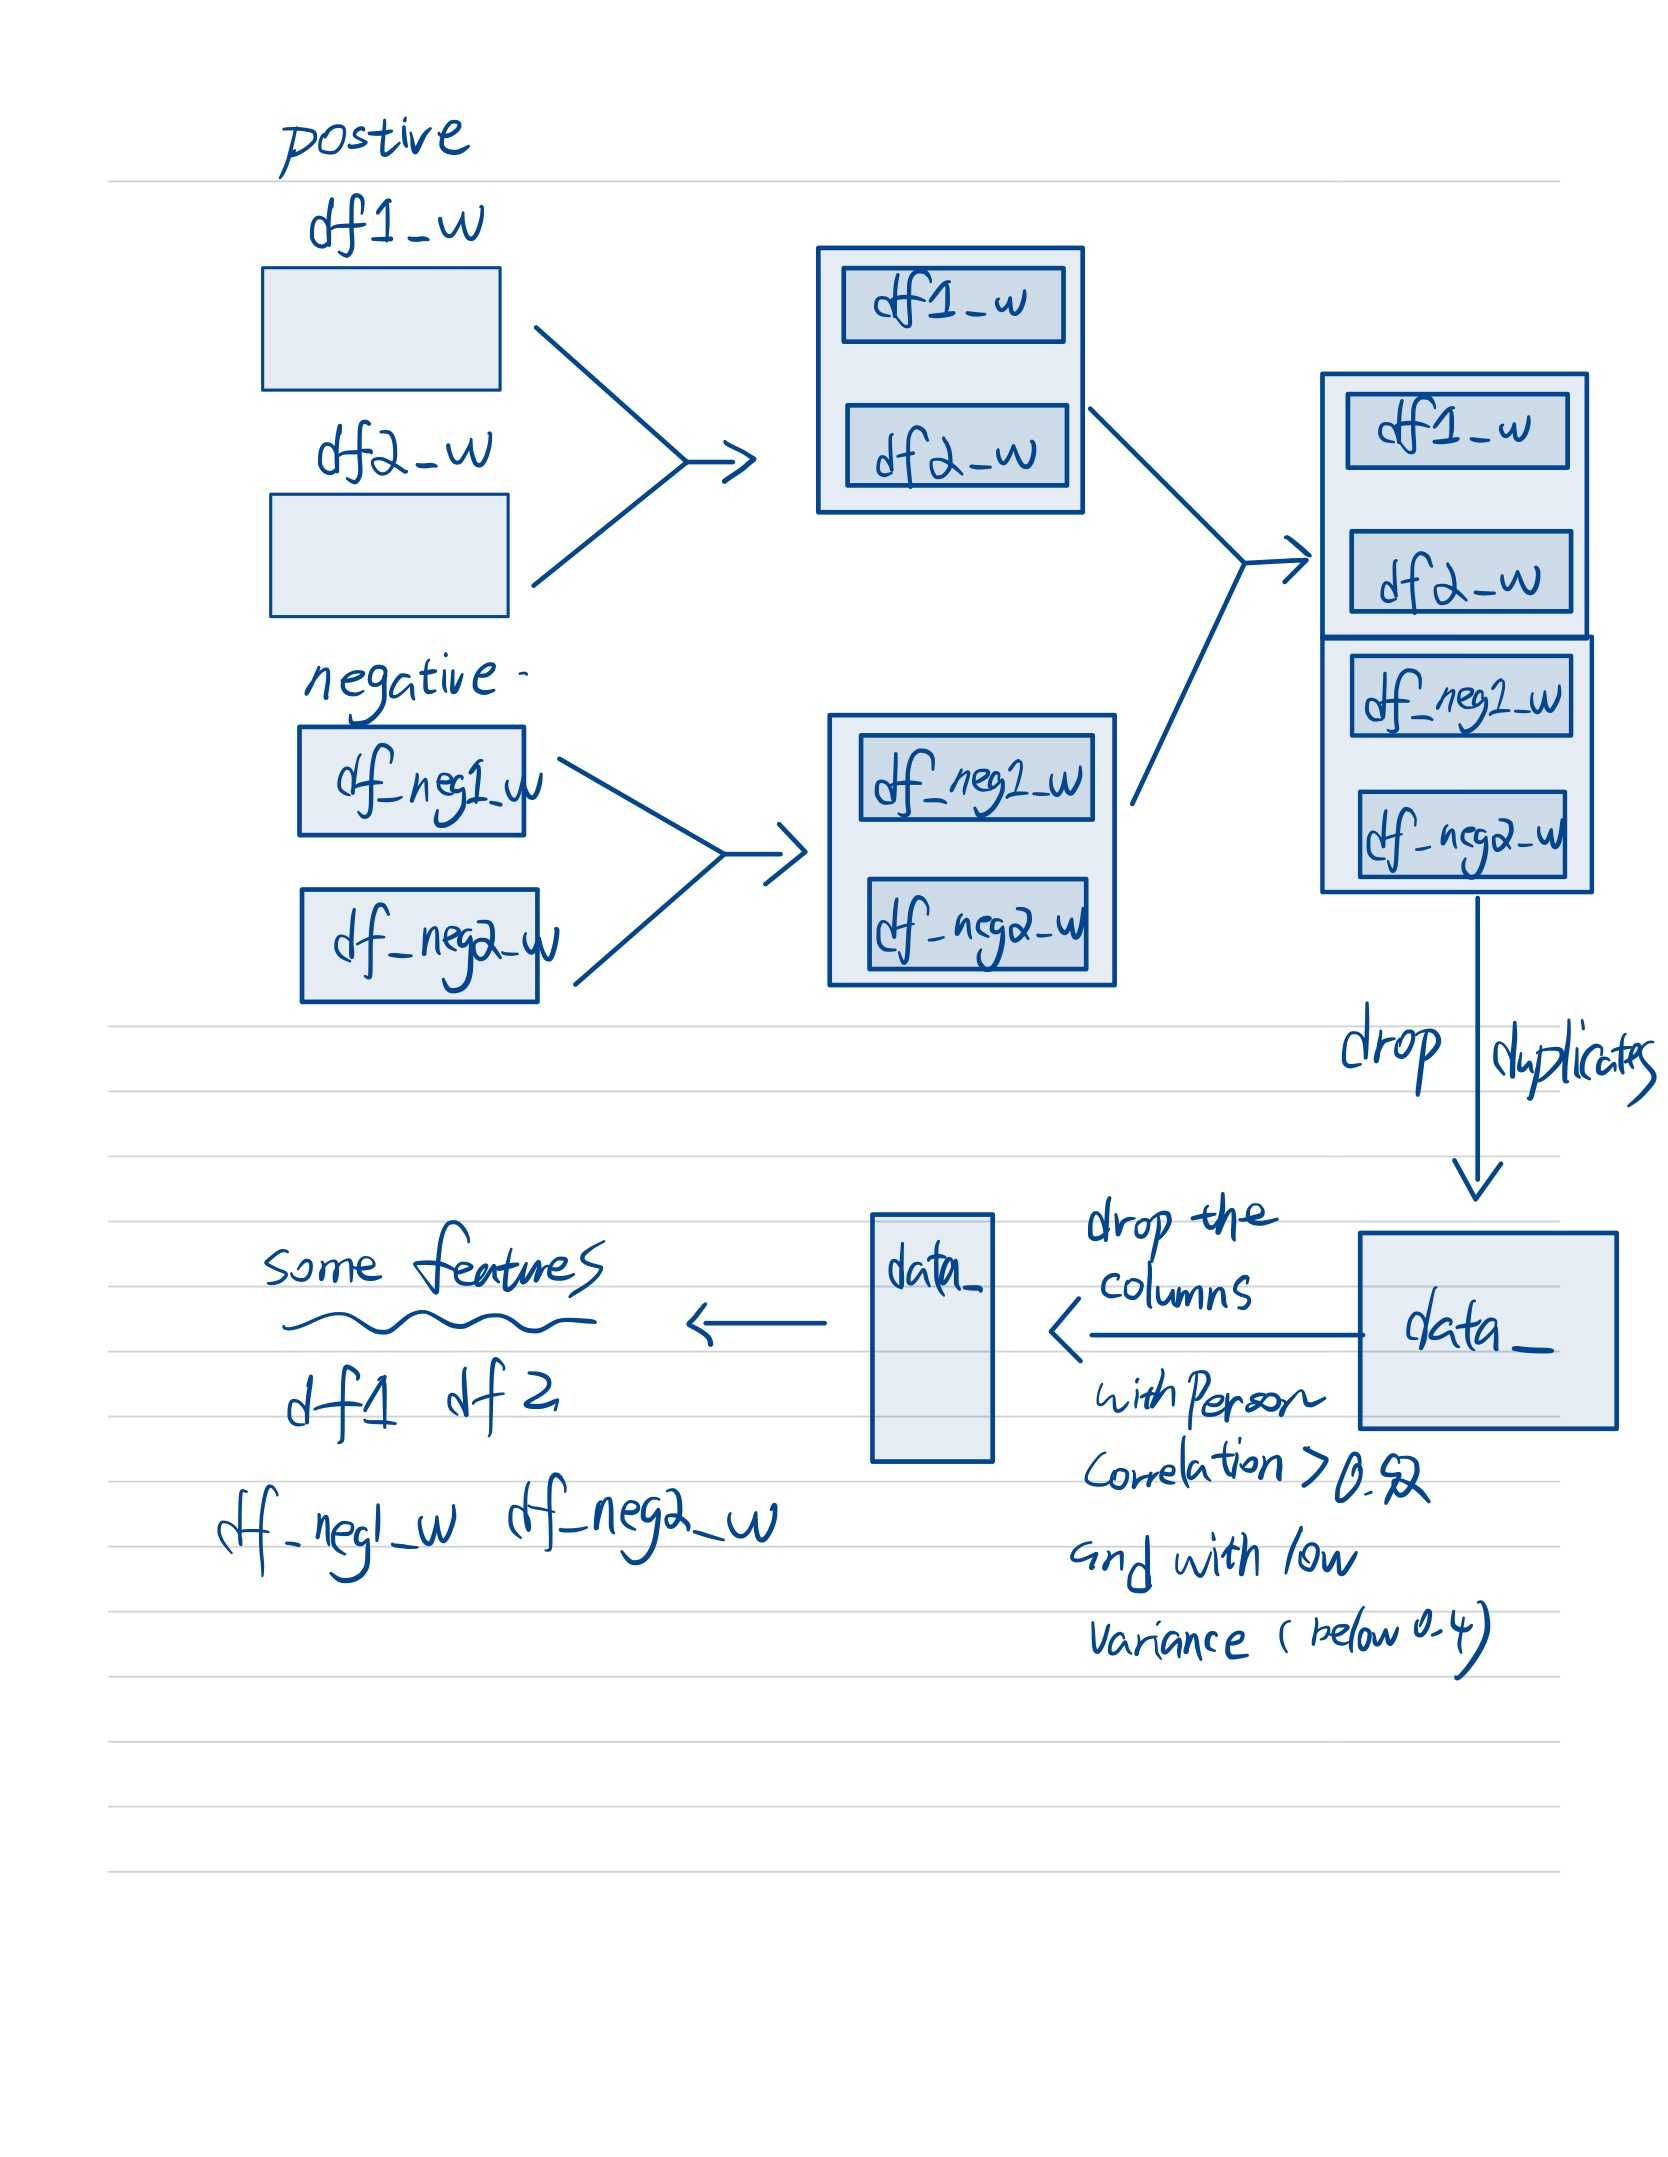



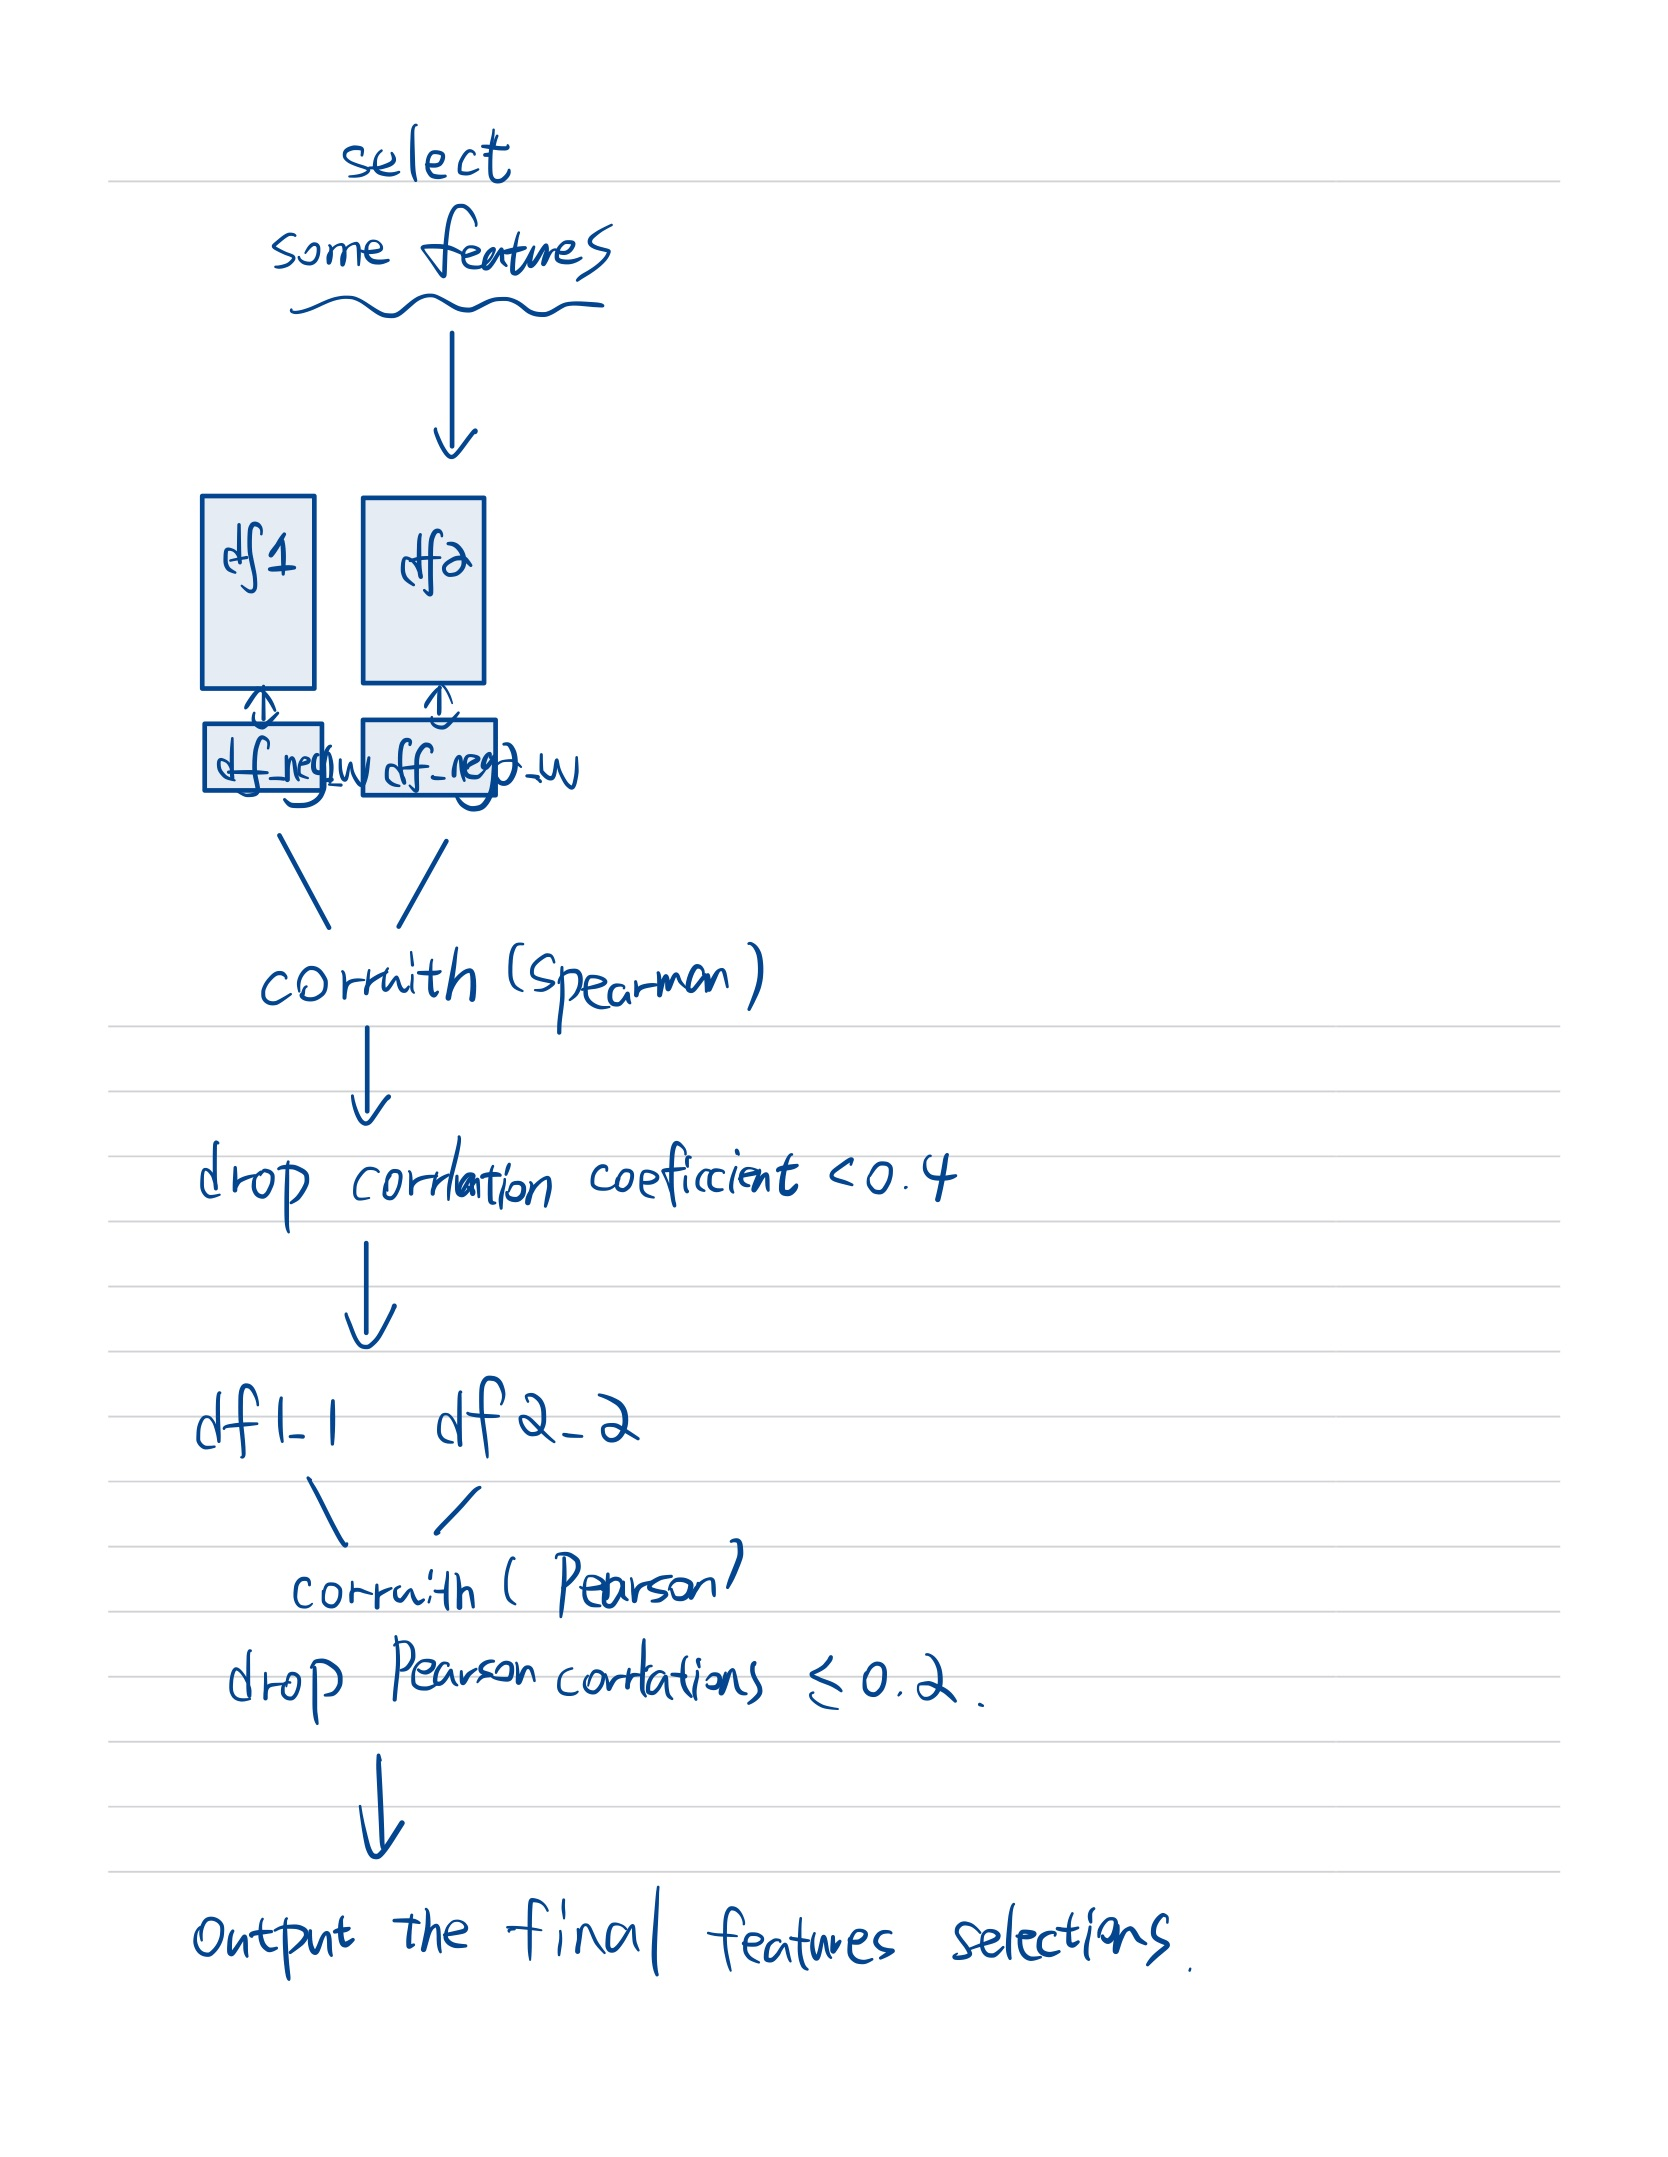



In [ ]:
# The two datasets are concateanted for identifing the highly correlated descriptors and remove them
## I do not understnd this method, it works in the binary classification? 11/17
df1_w=dataset1.iloc[:,2:]
df2_w=dataset2.iloc[:,2:]

df_neg1_w = negatives1.iloc[:,2:]
df_neg2_w = negatives2.iloc[:,2:]

data_postive = pd.concat([df1_w, df2_w])
data_negative = pd.concat([df_neg1_w, df_neg2_w])

data = pd.concat([data_postive, data_negative])
data_ = data.drop_duplicates(keep='first')


In [ ]:
# Drop the highly linearly correlated features among the datasets
# Create correlation matrix
corr_matrix1 = data_.corr().abs()

# Select upper triangle of correlation matrix
upper1 = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))

# Find index of feature columns with Pearson correlation greater than 0.92
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.92)]


In [ ]:
# Drop the descriptos will low variance, below 0.4
drop = data_.std()[data_.std() < 0.4].index.values
to_drop2= [x for x in drop if x not in to_drop1]
drop_final= to_drop1 + to_drop2

# Remove the selected features from the datasets
df1=df1_w.drop(columns=drop_final)
df1=df1.fillna(0)
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)


df2=df2_w.drop(columns=drop_final)
df2=df2.fillna(0)
df2 = df2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

df_neg1_w=df_neg1_w.drop(columns=drop_final)
df_neg1_w=df_neg1_w.fillna(0)
df_neg1_w = df_neg1_w.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

df_neg2_w=df_neg2_w.drop(columns=drop_final)
df_neg2_w=df_neg2_w.fillna(0)
df_neg2_w = df_neg2_w.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)



In [ ]:
# Calculate the Spearman correlations of the datasets

df1 = pd.concat([df1, df_neg1_w])# concat the first table with postive and negative 
df2 = pd.concat([df2, df_neg2_w])# concat the second table with postive and negative 

In [ ]:
cor = df1.corrwith(df2, axis=0, drop=False, method='spearman').abs()
corr=cor.sort_values(ascending=False)

In [ ]:
# Construct a vector w which is used to keep only the descriptors that are correlated higher than 0.30 using Spearman correlation
# In this vector, 1 is on the positions of the descriptors that have correlation coeficcient > 0.3,  and 0 otherwise
w = np.array(cor)
np.nan_to_num(w,0)
w[w<0.4] =0
w[w=='NaN']=0
w[w>=0.4] =1

# Multiply the two datasets with the vector w, such that the descriptors with lower correlation will become zero and removed 
df1 = df1*w
df2 = df2*w

df1_1 = df1.loc[:, (df1 != 0).any(axis=0)]
df2_2 = df2.loc[:, (df2 != 0).any(axis=0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [ ]:
# Calculate the Pearson correlations of the datasets 
cort= df1_1.corrwith(df2_2, axis=0, drop=False, method='pearson').abs()
corrt=cort.sort_values(ascending=False)

In [ ]:
# Keep only descriptors with Pearson correlations > 0.2
w = np.array(cort)
np.nan_to_num(w,0)
w[w<0.4]=0
w[w>=0.4]=1
df1_1 = df1_1*w
df2_2 = df2_2*w
df1_1 = df1_1.loc[:, (df1_1 != 0).any(axis=0)]
df2_2 = df2_2.loc[:, (df2_2 != 0).any(axis=0)]

In [ ]:
# Print out the p-value
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr

for i in df1_1.columns.values:
  print("Descriptor:%s"% i + " " + 'Correlation:%2f' %  pearsonr(df1_1[i].values, df2_2[i].values)[0] + "  " + "p-value:%2f" %  pearsonr(df1_1[i].values, df2_2[i].values)[1])

#Save to a list the important features and then from both the positives and negatives keep only these features

Descriptor:ABC Correlation:-0.416334  p-value:0.000000
Descriptor:ABCGG Correlation:-0.523768  p-value:0.000000
Descriptor:SpAbs_A Correlation:-0.420790  p-value:0.000000
Descriptor:LogEE_A Correlation:-0.740078  p-value:0.000000
Descriptor:VE1_A Correlation:-0.535533  p-value:0.000000
Descriptor:nAtom Correlation:-0.412485  p-value:0.000000
Descriptor:ATS0dv Correlation:-0.419304  p-value:0.000000
Descriptor:ATS1Z Correlation:-0.428643  p-value:0.000000
Descriptor:AATS5v Correlation:-0.486234  p-value:0.000000
Descriptor:AATS6v Correlation:-0.513864  p-value:0.000000
Descriptor:AATS7v Correlation:-0.518898  p-value:0.000000
Descriptor:AATS8v Correlation:-0.478953  p-value:0.000000
Descriptor:AATS7se Correlation:-0.558450  p-value:0.000000
Descriptor:AATS8se Correlation:-0.695904  p-value:0.000000
Descriptor:AATS6p Correlation:-0.532834  p-value:0.000000
Descriptor:AATS7p Correlation:-0.552364  p-value:0.000000
Descriptor:AATS8p Correlation:-0.542454  p-value:0.000000
Descriptor:ATSC0d

In [ ]:
selected_features = df1_1.columns
selected_features

Index(['ABC', 'ABCGG', 'SpAbs_A', 'LogEE_A', 'VE1_A', 'nAtom', 'ATS0dv',
       'ATS1Z', 'AATS5v', 'AATS6v', 'AATS7v', 'AATS8v', 'AATS7se', 'AATS8se',
       'AATS6p', 'AATS7p', 'AATS8p', 'ATSC0dv', 'AATSC2dv', 'AATSC3v',
       'MATS2dv', 'MATS3dv', 'MATS1d', 'MATS2d', 'MATS3Z', 'GATS7c', 'GATS6dv',
       'GATS7dv', 'GATS8dv', 'GATS5d', 'GATS6d', 'GATS7d', 'GATS8d', 'GATS7s',
       'GATS8s', 'GATS7Z', 'GATS8Z', 'GATS7m', 'GATS8m', 'GATS7v', 'GATS8v',
       'GATS7se', 'GATS8se', 'GATS8pe', 'GATS7are', 'GATS8are', 'GATS7p',
       'GATS8p', 'BCUTdv-1h', 'BCUTd-1h', 'BCUTs-1l', 'BCUTv-1l', 'BCUTi-1h',
       'SpMAD_DzZ', 'SpMAD_Dzse', 'AETA_eta', 'AETA_eta_R', 'AETA_eta_F',
       'IC3', 'MIC1', 'MIC3', 'GGI3', 'Radius', 'Vabc'],
      dtype='object')

In [ ]:
selected_features.shape

(64,)

# 4. Normalization and Concat_bidirectional of Dataset

## 4.1  Normalization with positives

In [ ]:
#get the postive data and fillna to 0
df1=dataset1.iloc[:,2:]
df1 = df1.fillna(0)
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(0)
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
df2 = df2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

#select feature
df1 = df1[selected_features]
df2 = df2[selected_features]

print(df1.shape)
print(df2.shape)

(1861, 64)
(1861, 64)


In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['id'], dataset11, dataset22], axis=1), pd.concat([dataset1['id'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
# Standarize the dataset

X_scaler = MinMaxScaler()

df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
positive_data = concat_bidirectional(df1_scaled,df2_scaled)

In [ ]:
# Assing the label = 1 for all the positive data
positive_data['label']=1
positive_data

,id,ABC,ABCGG,SpAbs_A,LogEE_A,VE1_A,nAtom,ATS0dv,ATS1Z,AATS5v,AATS6v,AATS7v,AATS8v,AATS7se,AATS8se,AATS6p,AATS7p,AATS8p,ATSC0dv,AATSC2dv,AATSC3v,MATS2dv,MATS3dv,MATS1d,MATS2d,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,...,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,GATS7v,GATS8v,GATS7se,GATS8se,GATS8pe,GATS7are,GATS8are,GATS7p,GATS8p,BCUTdv-1h,BCUTd-1h,BCUTs-1l,BCUTv-1l,BCUTi-1h,SpMAD_DzZ,SpMAD_Dzse,AETA_eta,AETA_eta_R,AETA_eta_F,IC3,MIC1,MIC3,GGI3,Radius,Vabc,label
0,ADOSOE,0.361714,0.390741,0.383579,0.808116,0.620343,0.355469,0.456478,0.293645,0.357914,0.456180,0.325860,0.398660,0.482759,0.521104,0.359880,0.169557,0.335312,0.486108,0.675950,0.593983,0.829969,0.623272,0.839421,0.816992,0.561052,0.239149,0.330803,0.327308,0.256410,0.486167,0.481913,0.380433,0.297097,0.221826,0.093552,0.177790,0.098720,0.180036,0.098802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.252840,0.433003,0.612422,0.234305,0.000000,0.201729,0.128834,0.296296,0.067386,1
1,ASOPUV,0.072870,0.092435,0.069125,0.496854,0.249049,0.054688,0.049391,0.095690,0.376497,0.420327,0.408216,0.460807,0.469196,0.513061,0.431452,0.262307,0.460113,0.062111,0.378587,0.394701,0.577227,0.439033,0.797391,0.595572,0.409574,0.212289,0.171130,0.305484,0.511386,0.282749,0.319866,0.550828,0.606737,0.081599,0.135312,0.213673,0.047373,0.215895,0.050072,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.252840,0.433003,0.612422,0.244859,0.000000,0.208655,0.128834,0.296296,0.067386,1
2,ASOQIK,0.090118,0.103277,0.093597,0.540291,0.278228,0.074219,0.108896,0.101534,0.312667,0.455314,0.332425,0.461362,0.474228,0.543292,0.432838,0.198003,0.421182,0.120112,0.327690,0.474987,0.527387,0.424297,0.821995,0.627782,0.476401,0.098769,0.143745,0.155659,0.202648,0.294254,0.354435,0.369076,0.420555,0.083669,0.072291,0.182947,0.161700,0.181938,0.161071,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.252840,0.433003,0.612422,0.244859,0.000000,0.208655,0.128834,0.296296,0.067386,1
3,ASOQOQ,0.069120,0.082669,0.067423,0.486420,0.232649,0.048828,0.049908,0.085464,0.391895,0.475758,0.403578,0.415916,0.465572,0.509875,0.472935,0.246757,0.396023,0.055309,0.337361,0.444558,0.528323,0.443730,0.708324,0.556226,0.452987,0.158085,0.184486,0.279614,0.399812,0.316719,0.398855,0.566747,0.437078,0.078914,0.132938,0.186041,0.068890,0.189343,0.072293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.252840,0.433003,0.612422,0.244859,0.000000,0.208655,0.128834,0.296296,0.067386,1
4,BODCEE,0.353856,0.291728,0.377906,0.798778,0.589935,0.291016,0.424585,0.280862,0.306801,0.443085,0.366047,0.432832,0.473712,0.531058,0.348636,0.185433,0.342220,0.348737,0.382786,0.404887,0.577206,0.375522,0.665319,0.461081,0.317552,0.275464,0.246239,0.215621,0.267155,0.343131,0.371361,0.330176,0.283545,0.126917,0.131416,0.134633,0.090828,0.135399,0.090782,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

## 4.2 Normalization with negatives

In [ ]:
#get the negative data and fillna to 0

neg1= negatives1.iloc[:,2:]
neg1 = neg1.fillna(0)
neg2= negatives2.iloc[:,2:]
neg2 = neg2.fillna(0)
neg1 = neg1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
neg2 = neg2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)


#select feature
neg1 = neg1[selected_features]
neg2 = neg2[selected_features]

print(neg1.shape)
print(neg2.shape)



(11, 64)
(11, 64)


In [ ]:
#Scale the negatives based on the potitives
negative_1_scaled = pd.DataFrame(X_scaler.transform(neg1), columns=selected_features)
negative_2_scaled = pd.DataFrame(X_scaler.transform(neg2), columns=selected_features)
neg=pd.concat([negative_1_scaled, negative_2_scaled], axis =1)

def neg_concat_bidirectional(dataset11, dataset22):
  return pd.concat([pd.concat([negatives1['id'], dataset11, dataset22], axis=1), pd.concat([negatives1['id'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])

negatives_data = neg_concat_bidirectional(negative_1_scaled,negative_2_scaled)

In [ ]:
# Assing the label = 0 for all the negative data
negatives_data['label'] = 0
negatives_data

,id,ABC,ABCGG,SpAbs_A,LogEE_A,VE1_A,nAtom,ATS0dv,ATS1Z,AATS5v,AATS6v,AATS7v,AATS8v,AATS7se,AATS8se,AATS6p,AATS7p,AATS8p,ATSC0dv,AATSC2dv,AATSC3v,MATS2dv,MATS3dv,MATS1d,MATS2d,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,...,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,GATS7v,GATS8v,GATS7se,GATS8se,GATS8pe,GATS7are,GATS8are,GATS7p,GATS8p,BCUTdv-1h,BCUTd-1h,BCUTs-1l,BCUTv-1l,BCUTi-1h,SpMAD_DzZ,SpMAD_Dzse,AETA_eta,AETA_eta_R,AETA_eta_F,IC3,MIC1,MIC3,GGI3,Radius,Vabc,label
0,c60:picene,0.266307,0.174172,0.261059,0.749700,0.563035,0.109375,0.312957,0.194302,0.615228,0.903037,0.709673,0.864357,0.471282,0.526278,0.649233,0.331617,0.630433,0.000000,0.354378,0.419146,0.548718,0.437272,0.359076,0.446695,0.330189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.173883,0.222093,0.220150,0.276445,0.298395,0.337719,0.339310,0.303120,0.110162,0.121142,0.134081,0.103152,0.135029,0.103611,0.189012,0.189432,0.182634,0.126894,0.165441,0.203314,0.144598,0.131015,0.105630,0.541085,0.415832,0.361152,0.948343,0.058622,0.164796,0.164463,0.113797,0.251260,0.460012,0.582866,0.139867,0.297921,0.033129,0.185185,0.070940,0
1,c60:fluoroanthene,0.266307,0.174172,0.261059,0.749700,0.563035,0.109375,0.312957,0.194302,0.615228,0.903037,0.709673,0.864357,0.471282,0.526278,0.649233,0.331617,0.630433,0.000000,0.354378,0.419146,0.548718,0.437272,0.359076,0.446695,0.330189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.235778,0.225287,0.172112,0.000000,0.374648,0.226984,0.142152,0.000000,0.141875,0.000000,0.140831,0.000000,0.141827,0.000000,0.198528,0.000000,0.191829,0.000000,0.000000,0.213550,0.000000,0.137611,0.000000,0.540508,0.415118,0.368873,0.952480,0.055144,0.123448,0.123199,0.096800,0.219204,0.424411,0.465644,0.140703,0.223294,0.041104,0.111111,0.049811,0
2,"c60:1,9dicyanoanthracene",0.266307,0.174172,0.261059,0.749700,0.563035,0.109375,0.312957,0.194302,0.615228,0.903037,0.709673,0.864357,0.471282,0.526278,0.649233,0.331617,0.630433,0.000000,0.354378,0.419146,0.548718,0.437272,0.359076,0.446695,0.330189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.249862,0.369332,0.284969,0.141884,0.370281,0.269544,0.136466,0.095483,0.158503,0.013913,0.210182,0.082167,0.210852,0.083043,0.252620,0.165752,0.279104,0.023933,0.070961,0.329968,0.046404,0.158873,0.090694,0.672703,0.417983,0.360646,0.312827,0.530730,0.134148,0.133890,0.092104,0.243536,0.471814,0.510464,0.249379,0.274009,0.038650,0.148148,0.060676,0
3,"c60:9,10bis(phenylethyl)anthracene",0.266307,0.174172,0.261059,0.749700,0.563035,0.109375,0.312957,0.194302,0.615228,0.903037,0.709673,0.864357,0.471282,0.526278,0.649233,0.331617,0.630433,0.000000,0.354378,0.419146,0.548718,0.437272,0.359076,0.446695,0.330189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166584,0.274170,0.257460,0.278233,0.365368,0.495383,0.480735,0.320249,0.099996,0.106751,0.148672,0.113123,0.149724,0.113627,0.209581,0.207743,0.202509,0.139160,0.181434,0.225440,0.158576,0.145273,0.115840,0.550938,0.418049,0.360608,0.948135,0.059356,0.247555,0.247055,0.127764,0.283190,0.498905,0.618184,0.194784,0.309379,0.035890,0.259259,0.106600,0
4,c60:benzanthracene,0.266307,0.174172,0.261059,0.749700,0.563035,0.109375,0.312957,0.194302,0.615228,0.903037,0.709673,0.864357,0.471282,0.526278,0.649233,0.331617,0.630433,0.000000,0.354378,0.419146,0.548718,0.437272,0.359076,0.446695,0.330189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.214095,0.241230,0.242022,0.253257,0.329575,0.392421,0.325240,0.199235,0.133292,0.143870,0.157528

## 4.3 Normalization with unlabelled 

In [ ]:
# Replace errors with 0 on the unlabelled dataset
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(0)
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

final_11 = final_1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
final_22 = final_2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

In [ ]:
#select feature
final_11 = final_11[selected_features]
final_22 = final_22[selected_features]

print(final_11.shape)
print(final_22.shape)


(22791, 64)
(22791, 64)


In [ ]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)

In [ ]:
# Standarize the unlabeled data based on the labelled

final_11 = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_11.values, columns=final_11.columns)],axis=1) 
#skip the comb
unlabeled_1_scaled= final_11.iloc[:,1:]
final_1_scaled = pd.DataFrame(X_scaler.transform(unlabeled_1_scaled),columns=selected_features)

final_22 = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_22.values, columns=final_22.columns)],axis=1) 
#skip the comb
unlabeled_2_scaled= final_22.iloc[:,1:]
final_2_scaled = pd.DataFrame(X_scaler.transform(unlabeled_2_scaled),columns=selected_features)


In [ ]:
def unlabelled_concat_bidirectional(dataset11, dataset22):
  return pd.concat([pd.concat([final_11['comb'], dataset11, dataset22], axis=1), pd.concat([final_11['comb'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])

unlabelled_data = unlabelled_concat_bidirectional(final_1_scaled,final_2_scaled)

In [ ]:
unlabelled_data

,comb,ABC,ABCGG,SpAbs_A,LogEE_A,VE1_A,nAtom,ATS0dv,ATS1Z,AATS5v,AATS6v,AATS7v,AATS8v,AATS7se,AATS8se,AATS6p,AATS7p,AATS8p,ATSC0dv,AATSC2dv,AATSC3v,MATS2dv,MATS3dv,MATS1d,MATS2d,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,...,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,GATS7v,GATS8v,GATS7se,GATS8se,GATS8pe,GATS7are,GATS8are,GATS7p,GATS8p,BCUTdv-1h,BCUTd-1h,BCUTs-1l,BCUTv-1l,BCUTi-1h,SpMAD_DzZ,SpMAD_Dzse,AETA_eta,AETA_eta_R,AETA_eta_F,IC3,MIC1,MIC3,GGI3,Radius,Vabc
0,comb1,0.065622,0.076814,0.064544,0.477275,0.225288,0.042969,0.084385,0.047480,0.293355,0.336018,0.213185,0.154996,0.510338,0.542231,0.268702,0.107355,0.157702,0.061774,0.354961,0.427077,0.549278,0.388165,0.584513,0.449550,0.335890,0.302439,0.264594,0.363130,0.517770,0.352696,0.378479,0.180593,0.068594,0.258732,0.299694,0.204195,0.187696,0.201944,0.184818,...,0.361845,0.308609,0.267174,0.211113,0.000000,0.436722,0.325409,0.164194,0.000000,0.189084,0.000000,0.180742,0.000000,0.182021,0.000000,0.254790,0.000000,0.246192,0.000000,0.000000,0.274069,0.000000,0.176610,0.000000,0.547634,0.423936,0.359246,0.949618,0.059020,0.122123,0.121877,0.106883,0.233661,0.437667,0.555872,0.144481,0.287352,0.041104,0.111111,0.052342
1,comb2,0.065622,0.076814,0.064544,0.477275,0.225288,0.042969,0.084385,0.047480,0.293355,0.336018,0.213185,0.154996,0.510338,0.542231,0.268702,0.107355,0.157702,0.061774,0.354961,0.427077,0.549278,0.388165,0.584513,0.449550,0.335890,0.302439,0.264594,0.363130,0.517770,0.352696,0.378479,0.180593,0.068594,0.258732,0.299694,0.204195,0.187696,0.201944,0.184818,...,0.379253,0.269453,0.272579,0.213145,0.165164,0.414075,0.364316,0.196331,0.097303,0.165742,0.119857,0.168572,0.082903,0.169765,0.083272,0.237634,0.152247,0.229616,0.101985,0.132966,0.255616,0.116214,0.164718,0.084895,0.547482,0.423748,0.353592,0.947139,0.059756,0.131624,0.131358,0.112697,0.246578,0.453212,0.492251,0.142330,0.245161,0.035890,0.148148,0.061641
2,comb3,0.065622,0.076814,0.064544,0.477275,0.225288,0.042969,0.084385,0.047480,0.293355,0.336018,0.213185,0.154996,0.510338,0.542231,0.268702,0.107355,0.157702,0.061774,0.354961,0.427077,0.549278,0.388165,0.584513,0.449550,0.335890,0.302439,0.264594,0.363130,0.517770,0.352696,0.378479,0.180593,0.068594,0.258732,0.299694,0.204195,0.187696,0.201944,0.184818,...,0.371573,0.298894,0.294487,0.251568,0.196754,0.422233,0.446619,0.254748,0.110765,0.185285,0.152381,0.193054,0.102292,0.194420,0.102747,0.272146,0.187853,0.262963,0.125837,0.164063,0.292739,0.143393,0.188641,0.104749,0.550339,0.427283,0.350212,0.946217,0.061163,0.135877,0.135602,0.121564,0.259241,0.464781,0.492640,0.144832,0.249214,0.035890,0.148148,0.064172
3,comb4,0.065622,0.076814,0.064544,0.477275,0.225288,0.042969,0.084385,0.047480,0.293355,0.336018,0.213185,0.154996,0.510338,0.542231,0.268702,0.107355,0.157702,0.061774,0.354961,0.427077,0.549278,0.388165,0.584513,0.449550,0.335890,0.302439,0.264594,0.363130,0.517770,0.352696,0.378479,0.180593,0.068594,0.258732,0.299694,0.204195,0.187696,0.201944,0.184818,...,0.360635,0.330726,0.314258,0.297253,0.225000,0.417753,0.534722,0.324730,0.122414,0.205040,0.183929,0.220603,0.120344,0.222163,0.120879,0.310981,0.221003,0.300487,0.148043,0.193015,0.334512,0.168698,0.215559,0.123234,0.552623,0.430109,0.347523,0.945468,0.062356,0.140440,0.140156,0.129868,0.271145,0.475694,0.323697,0.145747,0.159786,0.033129,0.148148,0.066703
4,comb5,0.065622,0.076814,0.064544,0.477275,0.225288,0.042969,0.084385,0.047480,0.293355,0.336018,0.213185,0.154996,0.510338,0.542231,0.268702,0.107355,0.157702,0.061774,0.354961,0.427077,0.549278,0.388165,0.584513,0.449550,0.335890,0.302439,0.264594,0.363130,0.517770,0.352696,0.378479,0.180593,0.068594,0.258732,0.299694,0.204195,0.187696,0.201944,0.184818,...,0.292977,0.000011,0.098324,0.000000,0.000000,0.248041,0.088861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [ ]:
final_1

,0,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,ZINC000000354958,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
1,ZINC000000354958,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
2,ZINC000000354958,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
3,ZINC000000354958,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
4,ZINC000000354958,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22786,ZINC000079045456,17.273268,12.025541,0,0,28.737241,2.675131,5.141863,28.737241,1.436862,4.035371,4.157708,0.207885,2.118111,127.296420,6.364821,5.539666,20,25,30,20,0,0,0,10,0,20,0,0,0,0,0,0,0,0,0,250.0,325.0,525.0,570.0,...,0.000000e+00,0.000000e+00,0.00000,0.000000,0.259548,6,4,0.500,0.333333,188.5728203,5.643856,25,4.875197,5.831882,6.803505,7.779467,8.759512,9.741027,10.72373

#def the ZINC with SMILES (No need to execute)

In [ ]:
# Replace errors with 0 on the unlabelled dataset
final_11_smiles = pd.concat([pairs[0],mol1_data],axis=1)
final_22_smiles = pd.concat([pairs[1],mol2_data],axis=1)

print(final_11_smiles.shape)
print(final_22_smiles.shape)

# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11_smiles.shape[0]+1):
  comb.append('comb%s' % i)

final_11_smiles = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_11_smiles.values, columns=final_11_smiles.columns)],axis=1) 
final_22_smiles = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_22_smiles.values, columns=final_22_smiles.columns)],axis=1) 


unlabelled_data_smiles = pd.concat([final_11_smiles,final_22_smiles],axis=1)

(22791, 1614)
(22791, 1614)


In [ ]:
unlabelled_data_smiles
unlabelled_data_smiles.to_csv('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/Dataset/unlabelled_data_smiles.csv')

# 5. Machine Learning Part

## 5.1 DBSCAN on the positives (for Friday 20th)
The problem of this part is we cannot evaluate this algorithm

In [ ]:
#del the id and label column 
positive_data_w = positive_data.drop('id', axis=1) 
positive_data_w = positive_data_w.drop('label', axis=1) 
positive_data_w.head(2)

,ABC,ABCGG,SpAbs_A,LogEE_A,VE1_A,nAtom,ATS0dv,ATS1Z,AATS5v,AATS6v,AATS7v,AATS8v,AATS7se,AATS8se,AATS6p,AATS7p,AATS8p,ATSC0dv,AATSC2dv,AATSC3v,MATS2dv,MATS3dv,MATS1d,MATS2d,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,GATS7v,...,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,GATS7v,GATS8v,GATS7se,GATS8se,GATS8pe,GATS7are,GATS8are,GATS7p,GATS8p,BCUTdv-1h,BCUTd-1h,BCUTs-1l,BCUTv-1l,BCUTi-1h,SpMAD_DzZ,SpMAD_Dzse,AETA_eta,AETA_eta_R,AETA_eta_F,IC3,MIC1,MIC3,GGI3,Radius,Vabc
0,0.361714,0.390741,0.383579,0.808116,0.620343,0.355469,0.456478,0.293645,0.357914,0.456180,0.325860,0.398660,0.482759,0.521104,0.359880,0.169557,0.335312,0.486108,0.675950,0.593983,0.829969,0.623272,0.839421,0.816992,0.561052,0.239149,0.330803,0.327308,0.256410,0.486167,0.481913,0.380433,0.297097,0.221826,0.093552,0.177790,0.098720,0.180036,0.098802,0.197441,...,0.330189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.25284,0.433003,0.612422,0.234305,0.0,0.201729,0.128834,0.296296,0.067386
1,0.072870,0.092435,0.069125,0.496854,0.249049,0.054688,0.049391,0.095690,0.376497,0.420327,0.408216,0.460807,0.469196,0.513061,0.431452,0.262307,0.460113,0.062111,0.378587,0.394701,0.577227,0.439033,0.797391,0.595572,0.409574,0.212289,0.171130,0.305484,0.511386,0.282749,0.319866,0.550828,0.606737,0.081599,0.135312,0.213673,0.047373,0.215895,0.050072,0.277258,...,0.330189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.25284,0.433003,0.612422,0.244859,0.0,0.208655,0.128834,0.296296,0.067386


In [ ]:
positive_data_w.shape

(3722, 128)

https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

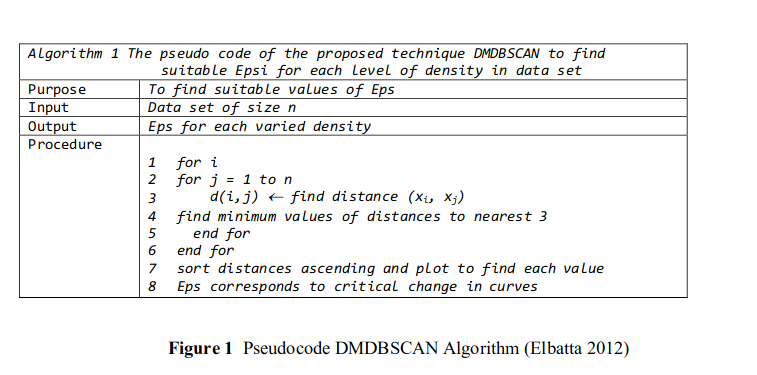

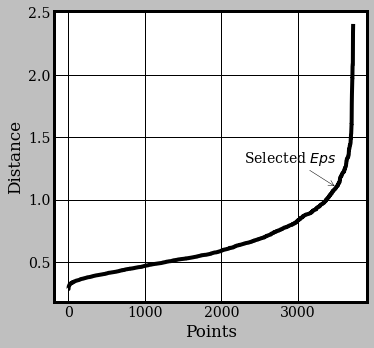

In [ ]:
from sklearn.neighbors import NearestNeighbors

plt.style.use('grayscale')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(positive_data_w)
distances, indices = neighbors.kneighbors(positive_data_w)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances) 
plt.annotate("Selected $\it{Eps}$", xy=(3500, 1.1), xytext=(2300, 1.3), arrowprops=dict(arrowstyle="->"))
plt.xlabel("Points")
plt.ylabel("Distance")

plt.savefig('Selete_EPS_DBSCAN.png', dpi=400, bbox_inches = 'tight')

In [ ]:
# from sklearn.cluster import DBSCAN
# res = []
# for eps in np.arange(0.001,1,0.05):
#     for min_samples in range(2,10):
#         dbscan = DBSCAN(eps = eps, min_samples = min_samples)
#         dbscan.fit(positive_data_w)
#         n_clusters = len([i for i in set(dbscan.labels_) if i != -1])
#         outliners = np.sum(np.where(dbscan.labels_ == -1, 1,0))
#         stats = str(pd.Series([i for i in dbscan.labels_ if i != -1]).value_counts().values)
#         res.append({'eps':eps,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})    
# output = pd.DataFrame(res)

In [ ]:
# output.loc[(output['eps'] >= 0.5) & (output['eps'] < 0.65),:]

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=1.15, min_samples=10).fit(positive_data_w)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 1


In [ ]:
from collections import  Counter
Counter(labels)

Counter({-1: 54, 0: 3668})

In [ ]:
# Remove the outers
labels = pd.DataFrame(labels)
positive_data_w_rm = positive_data_w.copy()
positive_data_w_rm['label'] = labels
positive_data_w_rm = positive_data_w_rm[positive_data_w_rm.label != -1]
positive_data_w_rm = positive_data_w_rm.drop('label', axis=1)  
positive_data_w_rm.shape

(3662, 128)

In [ ]:
positive_data_w_rm.head(3)

,ABC,ABCGG,SpAbs_A,LogEE_A,VE1_A,nAtom,ATS0dv,ATS1Z,AATS5v,AATS6v,AATS7v,AATS8v,AATS7se,AATS8se,AATS6p,AATS7p,AATS8p,ATSC0dv,AATSC2dv,AATSC3v,MATS2dv,MATS3dv,MATS1d,MATS2d,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,GATS7v,...,MATS3Z,GATS7c,GATS6dv,GATS7dv,GATS8dv,GATS5d,GATS6d,GATS7d,GATS8d,GATS7s,GATS8s,GATS7Z,GATS8Z,GATS7m,GATS8m,GATS7v,GATS8v,GATS7se,GATS8se,GATS8pe,GATS7are,GATS8are,GATS7p,GATS8p,BCUTdv-1h,BCUTd-1h,BCUTs-1l,BCUTv-1l,BCUTi-1h,SpMAD_DzZ,SpMAD_Dzse,AETA_eta,AETA_eta_R,AETA_eta_F,IC3,MIC1,MIC3,GGI3,Radius,Vabc
0,0.361714,0.390741,0.383579,0.808116,0.620343,0.355469,0.456478,0.293645,0.357914,0.456180,0.325860,0.398660,0.482759,0.521104,0.359880,0.169557,0.335312,0.486108,0.675950,0.593983,0.829969,0.623272,0.839421,0.816992,0.561052,0.239149,0.330803,0.327308,0.256410,0.486167,0.481913,0.380433,0.297097,0.221826,0.093552,0.177790,0.098720,0.180036,0.098802,0.197441,...,0.330189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.25284,0.433003,0.612422,0.234305,0.0,0.201729,0.128834,0.296296,0.067386
1,0.072870,0.092435,0.069125,0.496854,0.249049,0.054688,0.049391,0.095690,0.376497,0.420327,0.408216,0.460807,0.469196,0.513061,0.431452,0.262307,0.460113,0.062111,0.378587,0.394701,0.577227,0.439033,0.797391,0.595572,0.409574,0.212289,0.171130,0.305484,0.511386,0.282749,0.319866,0.550828,0.606737,0.081599,0.135312,0.213673,0.047373,0.215895,0.050072,0.277258,...,0.330189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.25284,0.433003,0.612422,0.244859,0.0,0.208655,0.128834,0.296296,0.067386
2,0.090118,0.103277,0.093597,0.540291,0.278228,0.074219,0.108896,0.101534,0.312667,0.455314,0.332425,0.461362,0.474228,0.543292,0.432838,0.198003,0.421182,0.120112,0.327690,0.474987,0.527387,0.424297,0.821995,0.627782,0.476401,0.098769,0.143745,0.155659,0.202648,0.294254,0.354435,0.369076,0.420555,0.083669,0.072291,0.182947,0.161700,0.181938,0.161071,0.211155,...,0.330189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.574354,0.456998,0.343017,0.946638,0.076529,0.205238,0.204823,0.25284,0.433003,0.612422,0.244859,0.0,0.208655,0.128834,0.296296,0.067386


## 5.2 SMOTE on the negatives (for Friday 27th)

In [ ]:
#get negative data with label
negatives_data_w = negatives_data.drop('id',axis=1) #with label

#set the postive label to 1
positive_data_w_rm['label'] = 1
positive_data_w_rm.head(2)

# merge the postive (DBSCAN) and negative
X = pd.concat([positive_data_w_rm,negatives_data_w])
y = X['label'].values

# remove the labels
X = X.drop('label',axis = 1)
# set X to Numpy array
X = X.values

In [ ]:
print(X.shape)
print(y.shape)

(3684, 128)
(3684,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2763, 128)
(2763,)
(921, 128)
(921,)


In [ ]:
!sudo pip install imbalanced-learn

## 5.3 OverSampling+UnderSampling Pipeline


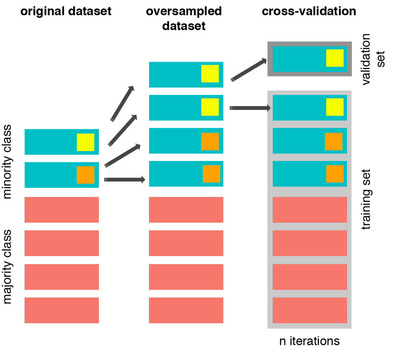

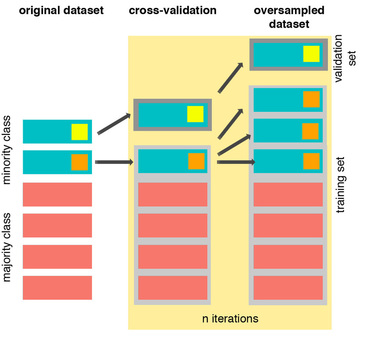

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer


# define pipeline Let the X_train = y_train ~ 1098
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=1)

pipeline = make_pipeline(SMOTE(sampling_strategy=0.4),RandomUnderSampler(sampling_strategy=1),RandomForestClassifier(n_estimators=200,max_depth =  12, oob_score = True,  random_state=13,class_weight = {0:1,1:100}, n_jobs = -1))
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model

Matthew = make_scorer(matthews_corrcoef)
scores = cross_val_score(pipeline, X_train, y_train, scoring=Matthew, cv=cv, n_jobs=-1)
# summarize performance
print('Mean Matthew: %.3f'% mean(scores))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mean Matthew: 0.501


GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13],
    'class_weight':[{1: w} for w in [1,2,5,10,100,1000,10000,30000,35000]]
}

new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(pipeline, param_grid=new_params, cv=cv, scoring=Matthew,
                        return_train_score=True)
grid_imba.fit(X_train, y_train)

In [ ]:
grid_imba.best_params_

{'randomforestclassifier__class_weight': {1: 100},
 'randomforestclassifier__max_depth': 12,
 'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__random_state': 13}

In [ ]:
grid_imba.best_score_

0.5877586142159102

## 5.4 OverSampling+UnderSampling decompose

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import ensemble
from collections import Counter

# define model
model = ensemble.RandomForestClassifier(n_estimators=200,max_depth =  12, oob_score = True,  random_state=13,class_weight = {0:1,1:1000}, n_jobs = -1)
# define pipeline Let the X_train = y_train ~ 1098
over = SMOTE(sampling_strategy=0.4,random_state=13)
under = RandomUnderSampler(sampling_strategy=1,random_state=13)
X_res, y_res = over.fit_resample(X_train, y_train)
print(Counter(y_train))
X_res, y_res = under.fit_resample(X_res, y_res)
print(Counter(y_res))

Counter({1: 2747, 0: 16})
Counter({0: 1098, 1: 1098})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)
# Is a good moddel? 

0.7287014467900698

Confusion matrix, without normalization
[[  4   2]
 [  1 914]]


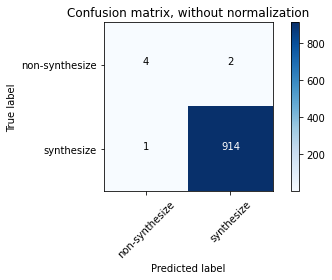

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non-synthesize','synthesize'],
                      title='Confusion matrix, without normalization')

In [ ]:
X_Zinc_w = unlabelled_data.iloc[0:22791,1:]

In [ ]:
y_pred_proba_Zinc = model.predict_proba(X_Zinc_w)
print(unlabelled_data.iloc[0:22791,:][y_pred_proba_Zinc[:,1:] > 0.999])

            comb       ABC    ABCGG  ...      GGI3    Radius      Vabc
1298    comb1299  0.073887  0.08173  ...  0.005521  0.074074  0.035449
1432    comb1433  0.073887  0.08173  ...  0.004141  0.074074  0.028652
1433    comb1434  0.073887  0.08173  ...  0.004141  0.074074  0.025384
1438    comb1439  0.073887  0.08173  ...  0.009816  0.074074  0.035449
3898    comb3899  0.113431  0.11015  ...  0.005521  0.074074  0.035449
...          ...       ...      ...  ...       ...       ...       ...
22504  comb22505  0.028067  0.03959  ...  0.043712  0.148148  0.088156
22505  comb22506  0.028067  0.03959  ...  0.030368  0.222222  0.090646
22508  comb22509  0.028067  0.03959  ...  0.028988  0.148148  0.076026
22509  comb22510  0.028067  0.03959  ...  0.026227  0.185185  0.068451
22514  comb22515  0.028067  0.03959  ...  0.066258  0.185185  0.143625

[631 rows x 129 columns]


In [ ]:
# Replace errors with 0 on the unlabelled dataset
final_1_org = pd.concat([pairs[0],mol1_data],axis=1)
final_1_org = final_1_org.fillna(0)
final_2_org = pd.concat([pairs[1],mol2_data],axis=1)
final_2_org = final_2_org.fillna(0)

final_11_org = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_1_org.values, columns=final_1_org.columns)],axis=1) 
final_22_org = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_2_org.values, columns=final_2_org.columns)],axis=1) 
a = pd.concat([final_11_org['comb'], final_1_org, final_2_org], axis=1)
b = pd.concat([final_11_org['comb'].apply(lambda x: f"{x}_"),final_2_org, final_1_org], axis=1)
a = a[['comb',0,1]]
b = b[['comb',1,0]]
a = a.rename(columns={0:'mol1',1:'mol2'})
b = b.rename(columns={1:'mol1',0:'mol2'})
unlabelled_org = pd.concat([a,b])
unlabelled_org = unlabelled_org.reset_index(drop=True)
unlabelled_org

In [ ]:
top_zinc_index = unlabelled_data.iloc[0:22791,:][y_pred_proba_Zinc[:,1:] == 1].index

In [ ]:
unlabelled_org.iloc[top_zinc_index,:]

,comb,mol1,mol2
1298,comb1299,ZINC000001693568,ZINC000000967522
1432,comb1433,ZINC000001693568,ZINC000000967534
1438,comb1439,ZINC000001693568,ZINC000001570209
3898,comb3899,ZINC000064624846,ZINC000000967522
4032,comb4033,ZINC000064624846,ZINC000000967534
...,...,...,...
22504,comb22505,ZINC000001845807,ZINC000001656970
22505,comb22506,ZINC000001845807,ZINC000001668172
22508,comb22509,ZINC000001845807,ZINC000002568170
22509,comb22510,ZINC000001845807,ZINC000012371961


In [ ]:
Predictions = unlabelled_org.iloc[top_zinc_index,1:].apply(pd.value_counts)
Predictions.to_csv('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/Dataset/Predictions.csv')

## 5.5 Evaluation metrics: ROC curve (for Friday 4th) #Is it going to be abandoned? Because ROC curve can't evaluate this kind of situation

In [ ]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [ ]:
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}".format(Accuracy))
#Precision 
Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))
#Recall 
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))
#F1 Score
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))
#F-beta score calculation
def fbeta(precision, recall, beta):
    return ((1+pow(beta,2))*precision*recall)/(pow(beta,2)*precision + recall)
            
f2 = fbeta(Precision, Recall, 2)
f0_5 = fbeta(Precision, Recall, 0.5)

print("F2 {:0.2f}".format(f2))
print("\nF0.5 {:0.2f}".format(f0_5))
#Specificity 
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

In [ ]:
#ROC
!pip install scikit-plot
import scikitplot as skplt #to make things easy
y_pred_proba = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

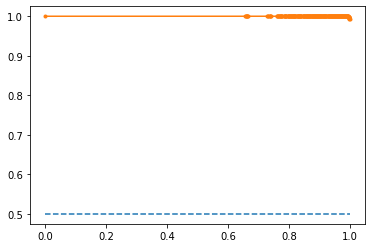

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
probs = model.predict_proba(X_test)
probs = probs[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test,probs)
auc_score = auc(recall, precision)

plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show()

## 5.6 Feature Importance- Chemical understanding (for Friday 4th)

In [ ]:
# Add the '_1' and '_2' at the end of each descriptor to denote the possition of the molecule in the vector


df_col = neg1.copy()
labels1 = df_col.rename(columns=lambda x: f"{x}_1")
labels2 = df_col.rename(columns=lambda x: f"{x}_2")
dataset1_labels = labels1.columns.values
dataset2_labels = labels2.columns.values
cols = np.concatenate((dataset1_labels, dataset2_labels))

In [ ]:
# the permutation based importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(RF_class, X, y)

sorted_idx = perm_importance.importances_mean.argsort()


In [ ]:
plt.figure(figsize=(30,20))
plt.barh(cols[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
# Import the libraries
!pip install shap

In [ ]:
import shap
X_test = pd.DataFrame(X_test, columns=cols) 
explainer = shap.TreeExplainer(RF_class)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar',layered_violin_max_num_bins=20, class_names=None, max_display=40,  show=False)